<a href="https://colab.research.google.com/github/johnfriesen/tree_envelope_in_bavarian_cities/blob/main/merge_climate_envelope_bavarian_cities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 42.0 MB/s eta 0:00:00


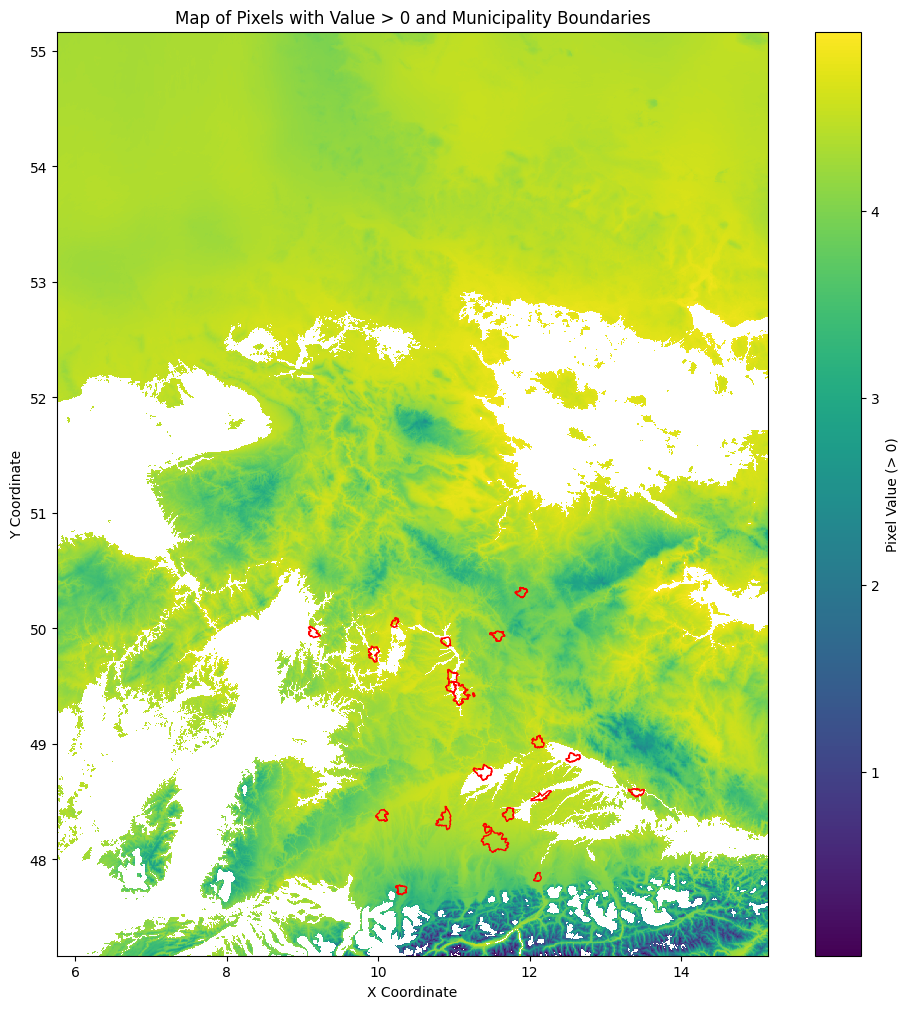

In [ ]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
import numpy as np

# Define file paths
raster_path = "Rotbuche_2071-2100.tif"
shapefile_path = "VG250_GEM.shp"

# Load the raster and read channel one
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)  # first band
    transform = src.transform
    # Create a version of the raster that only keeps pixels > 0, others set to nan
    raster_valid = np.where(raster_data > 0, raster_data, np.nan)
    bounds = src.bounds  # used for plotting the raster correctly

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Define your list of ARS codes
ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf['ARS_0'].isin(ars_list)]

# Reproject the shapefile to the raster's CRS if needed
if gdf_filtered.crs != src.crs:
    gdf_filtered = gdf_filtered.to_crs(src.crs)

# Plot the raster and municipality boundaries
fig, ax = plt.subplots(figsize=(12, 12))
# Plot the raster with extent defined by the raster bounds (to correctly position pixels)
im = ax.imshow(raster_valid,
               extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
               cmap='viridis',
               interpolation='none')
# Overlay municipality boundaries
gdf_filtered.boundary.plot(ax=ax, edgecolor='red', linewidth=1)

# Add a colorbar for the raster
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Pixel Value (> 0)')

ax.set_title('Map of Pixels with Value > 0 and Municipality Boundaries')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
plt.show()


           ARS_0  TOTAL_PIXELS  VALID_PIXELS  NO_INFO_PIXELS   PCT_VALID
0   091610000000           236            24             212   10.169492
1   091620000000           538           538               0  100.000000
2   091630000000            62            62               0  100.000000
3   091740115115            59            59               0  100.000000
4   091780124124           157           146              11   92.993631
5   092610000000           115            37              78   32.173913
6   092620000000           125            36              89   28.800000
7   092630000000           121             0             121    0.000000
8   093620000000           140           140               0  100.000000
9   094610000000           100            46              54   46.000000
10  094620000000           119           119               0  100.000000
11  094640000000           108           108               0  100.000000
12  095620000000           137            77       

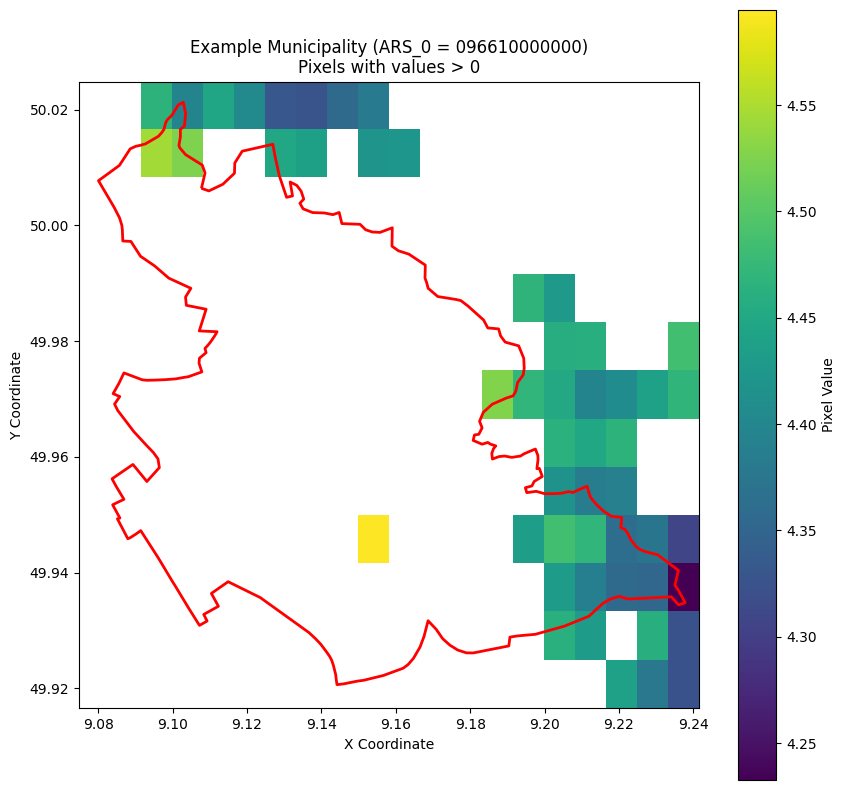

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
import numpy as np
import pandas as pd
from shapely.geometry import box
import matplotlib.pyplot as plt

# File paths
raster_path = "Rotbuche_2071-2100.tif"
shapefile_path = "VG250_GEM.shp"

# Load the shapefile and filter by ARS codes
gdf = gpd.read_file(shapefile_path)
ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf['ARS_0'].isin(ars_list)]

results = []

with rasterio.open(raster_path) as src:
    # Reproject the GeoDataFrame if needed so the CRS matches the raster
    if gdf_filtered.crs != src.crs:
        gdf_filtered = gdf_filtered.to_crs(src.crs)

    for idx, row in gdf_filtered.iterrows():
        polygon = row.geometry

        # Use mask() to get the raster values over the polygon's bounding box.
        # filled=True returns a full array (with nodata values filled in).
        out_image, out_transform = mask(
            src,
            [polygon.__geo_interface__],
            crop=True,
            all_touched=True,
            filled=True
        )
        data_filled = out_image[0]  # First band

        # Create a binary mask of the polygon using geometry_mask.
        # Set invert=True so that pixels inside the polygon are True.
        poly_mask = geometry_mask(
            [polygon.__geo_interface__],
            out_shape=data_filled.shape,
            transform=out_transform,
            invert=True
        )

        # Count total pixels inside the polygon based on the geometry mask.
        total_pixels = np.sum(poly_mask)  # True is 1; gives count of pixels inside

        # Count valid pixels: pixels inside the polygon (poly_mask True) with values > 0.
        valid_pixels = np.sum((data_filled > 0) & poly_mask)

        # "No information" pixels are those inside the polygon that are not valid.
        no_info_pixels = total_pixels - valid_pixels

        pct_valid = (valid_pixels / total_pixels * 100) if total_pixels > 0 else 0

        results.append({
            "ARS_0": row["ARS_0"],
            "TOTAL_PIXELS": int(total_pixels),
            "VALID_PIXELS": int(valid_pixels),
            "NO_INFO_PIXELS": int(no_info_pixels),
            "PCT_VALID": pct_valid
        })

df_results = pd.DataFrame(results)
print(df_results)

# ---------------------------
# Plot a map showing the pixels (values > 0)
# ---------------------------
# For visualization, we create a raster version where pixels outside the polygon are masked.
# Here we'll use the first municipality from our filtered set for demonstration.

# Let's pick one municipality (e.g., the first one)
example_geom = [gdf_filtered.iloc[15].geometry.__geo_interface__]

with rasterio.open(raster_path) as src:
    out_image, out_transform = mask(src, example_geom, crop=True, all_touched=True, filled=False)
    data = out_image[0]  # masked array

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))
# Plot the masked array. The masked areas will not be shown.
im = ax.imshow(data.data,
               extent=(
                   out_transform[2],
                   out_transform[2] + out_transform[0] * data.shape[1],
                   out_transform[5] + out_transform[4] * data.shape[0],
                   out_transform[5]),
               cmap='viridis',
               interpolation='none')

# Overlay the boundary of the example municipality
gdf_filtered.iloc[[15]].boundary.plot(ax=ax, edgecolor='red', linewidth=2)

ax.set_title(f"Example Municipality (ARS_0 = {gdf_filtered.iloc[15]['ARS_0']})\nPixels with values > 0")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
fig.colorbar(im, ax=ax, label='Pixel Value')
plt.show()


           City                   Species Time_Frame  TOTAL_PIXELS  \
0    Ingolstadt                  Rotbuche  2011-2040           236   
1    Ingolstadt                  Rotbuche  2041-2070           236   
2    Ingolstadt                  Rotbuche  2071-2100           236   
3    Ingolstadt                Spitzahorn  2011-2040           236   
4    Ingolstadt                Spitzahorn  2041-2070           236   
..          ...                       ...        ...           ...   
751     Neu-Ulm           Gemeine Robinie  2041-2070           143   
752     Neu-Ulm           Gemeine Robinie  2071-2100           143   
753     Neu-Ulm  Gewöhnliche Rosskastanie  2011-2040           143   
754     Neu-Ulm  Gewöhnliche Rosskastanie  2041-2070           143   
755     Neu-Ulm  Gewöhnliche Rosskastanie  2071-2100           143   

     VALID_PIXELS   PCT_VALID  
0             236  100.000000  
1             236  100.000000  
2              24   10.169492  
3             236  100.000000  

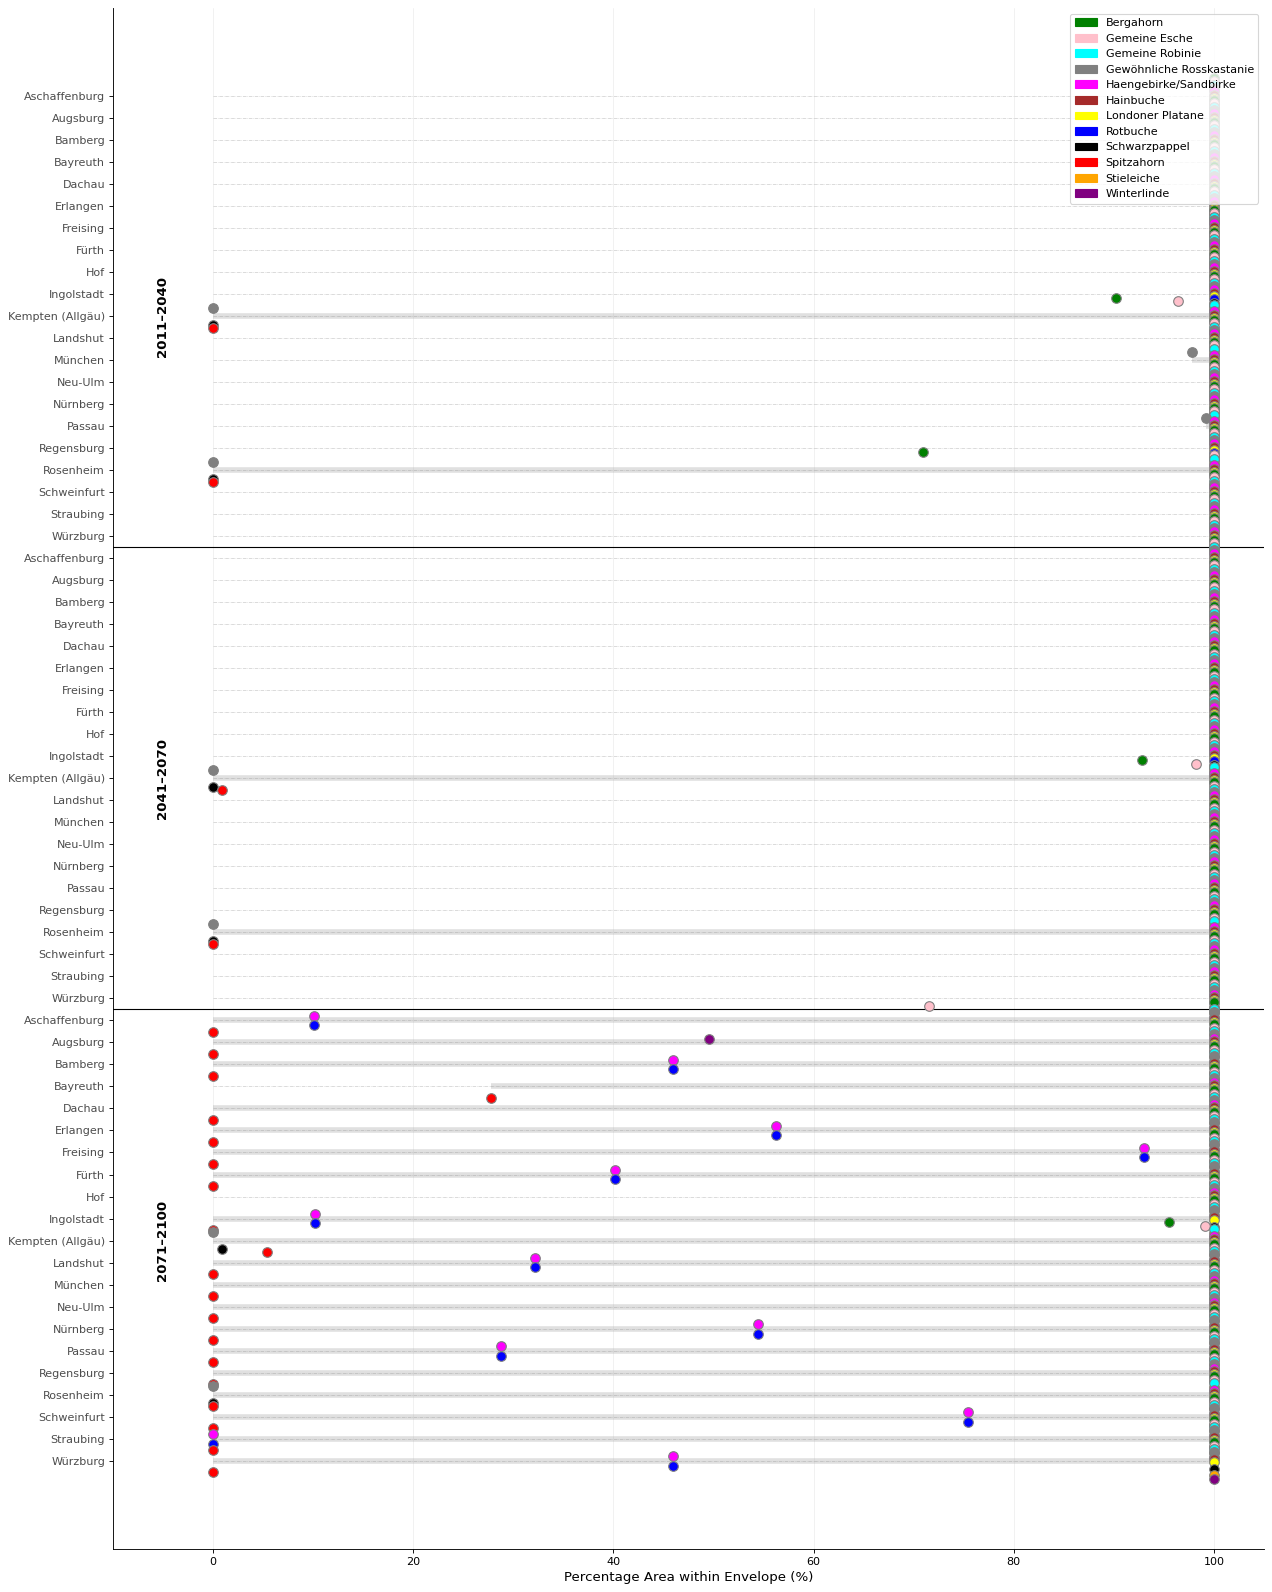

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# -----------------------------------------------------------------
# 1. Set up the mapping of (species, time_frame) to raster file paths
# -----------------------------------------------------------------
raster_files = {
    ('Rotbuche', '2011-2040'): "Rotbuche_2011-2040.tif",
    ('Rotbuche', '2041-2070'): "Rotbuche_2041-2070.tif",
    ('Rotbuche', '2071-2100'): "Rotbuche_2071-2100.tif",
    ('Spitzahorn', '2011-2040'): "Spitzahorn_2011-2040.tif",
    ('Spitzahorn', '2041-2070'): "Spitzahorn_2041-2070.tif",
    ('Spitzahorn', '2071-2100'): "Spitzahorn_2071-2100.tif",
    ('Bergahorn', '2011-2040'): "Bergahorn_2011-2040.tif",
    ('Bergahorn', '2041-2070'): "Bergahorn_2041-2070.tif",
    ('Bergahorn', '2071-2100'): "Bergahorn_2071-2100.tif",
    ('Stieleiche', '2011-2040'): "Stieleiche_2011-2040.tif",
    ('Stieleiche', '2041-2070'): "Stieleiche_2041-2070.tif",
    ('Stieleiche', '2071-2100'): "Stieleiche_2071-2100.tif",
    ('Winterlinde', '2011-2040'): "Winterlinde_2011-2040.tif",
    ('Winterlinde', '2041-2070'): "Winterlinde_2041-2070.tif",
    ('Winterlinde', '2071-2100'): "Winterlinde_2071-2100.tif",
    ('Haengebirke/Sandbirke', '2011-2040'): "Haengebirke_Sandbirke_2011-2040.tif",
    ('Haengebirke/Sandbirke', '2041-2070'): "Haengebirke_Sandbirke_2041-2070.tif",
    ('Haengebirke/Sandbirke', '2071-2100'): "Haengebirke_Sandbirke_2071-2100.tif",
    ('Schwarzpappel', '2011-2040'): "Schwarz_pappel_2011-2040.tif",
    ('Schwarzpappel', '2041-2070'): "Schwarz_pappel_2041-2070.tif",
    ('Schwarzpappel', '2071-2100'): "Schwarz_pappel_2071-2100.tif",
    ('Hainbuche', '2011-2040'): "Hainbuche_2011-2040.tif",
    ('Hainbuche', '2041-2070'): "Hainbuche_2041-2070.tif",
    ('Hainbuche', '2071-2100'): "Hainbuche_2071-2100.tif",
    ('Gemeine Esche', '2011-2040'): "Gemeine_Esche_2011-2040.tif",
    ('Gemeine Esche', '2041-2070'): "Gemeine_Esche_2041-2070.tif",
    ('Gemeine Esche', '2071-2100'): "Gemeine_Esche_2071-2100.tif",
    ('Londoner Platane', '2011-2040'): "nh2011_Londoner_Platane.tif",
    ('Londoner Platane', '2041-2070'): "nh2041_Londoner_Platane.tif",
    ('Londoner Platane', '2071-2100'): "nh2071_Londoner_Platane.tif",
    ('Gemeine Robinie', '2011-2040'): "Gemeine_Robinie_2011-2040.tif",
    ('Gemeine Robinie', '2041-2070'): "Gemeine_Robinie_2041-2070.tif",
    ('Gemeine Robinie', '2071-2100'): "Gemeine_Robinie_2071-2100.tif",
    ('Gewöhnliche Rosskastanie', '2011-2040'): "nh2011_Gewoehnliche_Rosskastanie.tif",
    ('Gewöhnliche Rosskastanie', '2041-2070'): "nh2041_Gewoehnliche_Rosskastanie.tif",
    ('Gewöhnliche Rosskastanie', '2071-2100'): "nh2071_Gewoehnliche_Rosskastanie.tif"
}

# -----------------------------------------------------------------
# 2. Load the shapefile and filter by your ARS list (if needed)
#    We'll use the "GEN" column for city names.
# -----------------------------------------------------------------
shapefile_path = "VG250_GEM.shp"
gdf = gpd.read_file(shapefile_path)

ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf['ARS_0'].isin(ars_list)].copy()

# -----------------------------------------------------------------
# 3. Define a function to compute pixel metrics for a given polygon and raster.
# -----------------------------------------------------------------
def get_polygon_metrics(raster_path, polygon):
    with rasterio.open(raster_path) as src:
        # Extract the raster values over the polygon's bounding box.
        out_image, out_transform = mask(src, [polygon.__geo_interface__],
                                        crop=True, all_touched=True, filled=True)
        data_filled = out_image[0]  # first band

        # Create a geometry mask based solely on the polygon.
        poly_mask = geometry_mask([polygon.__geo_interface__],
                                  out_shape=data_filled.shape,
                                  transform=out_transform,
                                  invert=True)
        # Count total pixels inside the polygon (using the geometry mask)
        total_pixels = np.sum(poly_mask)
        # Count valid pixels (inside the polygon with value > 0)
        valid_pixels = np.sum((data_filled > 0) & poly_mask)
        pct_valid = (valid_pixels / total_pixels * 100) if total_pixels > 0 else 0

    return int(total_pixels), int(valid_pixels), pct_valid

# -----------------------------------------------------------------
# 4. Reproject the shapefile to the CRS of the rasters.
#    Here, we assume all rasters share the same CRS.
# -----------------------------------------------------------------
# Get the CRS from one of the rasters:
first_raster = list(raster_files.values())[0]
with rasterio.open(first_raster) as src:
    raster_crs = src.crs

if gdf_filtered.crs != raster_crs:
    gdf_filtered = gdf_filtered.to_crs(raster_crs)

# -----------------------------------------------------------------
# 5. Loop over each city (using the "GEN" column for names)
#    and each raster (species and time_frame) to compute metrics.
# -----------------------------------------------------------------
results = []
for idx, row in gdf_filtered.iterrows():
    city_name = row["GEN"]
    polygon = row.geometry
    for (species, time_frame), raster_file in raster_files.items():
        total_pixels, valid_pixels, pct_valid = get_polygon_metrics(raster_file, polygon)
        results.append({
            "City": city_name,
            "Species": species,
            "Time_Frame": time_frame,
            "TOTAL_PIXELS": total_pixels,
            "VALID_PIXELS": valid_pixels,
            "PCT_VALID": pct_valid
        })

df_results = pd.DataFrame(results)
print(df_results)
df_results.to_csv('results.csv', index=False)

# -----------------------------------------------------------------
# 6. Plotting: Prepare data and create a horizontal dot plot
#    comparing the percentage valid pixels for each city.
# -----------------------------------------------------------------
# Pivot the data for each time frame so that rows are cities and columns are tree species.
def pivot_time_frame(df, time_frame):
    group = df[df['Time_Frame'] == time_frame].pivot(index='City', columns='Species', values='PCT_VALID').reset_index()
    return group

group1 = pivot_time_frame(df_results, '2011-2040')
group2 = pivot_time_frame(df_results, '2041-2070')
group3 = pivot_time_frame(df_results, '2071-2100')

# Compute uncertainty margins dynamically over all species columns.
for group in [group1, group2, group3]:
    species_cols = [col for col in group.columns if col != 'City']
    group['Uncertainty_Min'] = group[species_cols].min(axis=1)
    group['Uncertainty_Max'] = group[species_cols].max(axis=1)

# Record the number of rows per group.
n1 = group1.shape[0]
n2 = group2.shape[0]
n3 = group3.shape[0]

# Concatenate the groups in order (earliest time frame first).
df_all = pd.concat([group1, group2, group3], ignore_index=True)

# Create y positions for each row and get city labels.
y_positions = np.arange(df_all.shape[0])
ytick_labels = df_all['City'].tolist()

# ----- Plotting -----
fig, ax = plt.subplots(figsize=(16, 20), dpi=80)

# Draw horizontal guide lines for each row (x-axis from 0 to 100%).
ax.hlines(y=y_positions, xmin=0, xmax=100, color='gray', alpha=0.5, linewidth=0.5, linestyles='dashdot')

# Draw thicker uncertainty margin lines behind the dots.
for i, row in df_all.iterrows():
    ax.hlines(y=i, xmin=row['Uncertainty_Min'], xmax=row['Uncertainty_Max'],
              color='lightgrey', linewidth=5, alpha=0.7, zorder=1)

# Define colors for every species.
colors = {
    'Rotbuche': 'blue',
    'Spitzahorn': 'red',
    'Bergahorn': 'green',
    'Stieleiche': 'orange',
    'Winterlinde': 'purple',
    'Hainbuche': 'brown',
    'Gemeine Esche': 'pink',
    'Gemeine Robinie': 'cyan',
    'Haengebirke/Sandbirke': 'magenta',
    'Schwarzpappel': 'black',
    'Londoner Platane': 'yellow',
    'Gewöhnliche Rosskastanie': 'gray'
}

# Determine species columns (all columns except 'City', 'Uncertainty_Min', and 'Uncertainty_Max').
species_columns = [col for col in df_all.columns if col not in ['City', 'Uncertainty_Min', 'Uncertainty_Max']]

# Neuer Plot-Bereich: Punkte für jede Baumart mit leicht vertikal versetzten Positionen.
offset_step = 0.15  # Bestimmt den Versatz; diesen Wert kannst du anpassen.
num_species = len(species_columns)
for i, row in df_all.iterrows():
    for j, species in enumerate(species_columns):
        # Berechne den Offset, sodass die Punkte gleichmäßig um die zentrale y-Position verteilt werden.
        offset = (j - (num_species - 1) / 2) * offset_step
        ax.scatter(row[species], i + offset, s=75, color=colors.get(species, 'black'),
                   edgecolors='gray', zorder=3)

# Set y-ticks to show city names.
ax.set_yticks(y_positions)
ax.set_yticklabels(ytick_labels, fontdict={'horizontalalignment': 'right'}, alpha=0.7)

# Invert the y-axis so that the earliest group appears on top.
ax.invert_yaxis()

# Add horizontal separator lines between time frame groups.
sep1 = n1 - 0.5
sep2 = n1 + n2 - 0.5
ax.axhline(y=sep1, color='black', linewidth=1)
ax.axhline(y=sep2, color='black', linewidth=1)

# Add period labels next to each group.
center_group1 = (n1 - 1) / 2
center_group2 = n1 + (n2 - 1) / 2
center_group3 = n1 + n2 + (n3 - 1) / 2
x_label = -5  # adjust x offset for period labels

ax.text(x_label, center_group1, "2011–2040", ha='center', va='center',
        rotation=90, fontsize=12, fontweight='bold')
ax.text(x_label, center_group2, "2041–2070", ha='center', va='center',
        rotation=90, fontsize=12, fontweight='bold')
ax.text(x_label, center_group3, "2071–2100", ha='center', va='center',
        rotation=90, fontsize=12, fontweight='bold')

# Set x-axis label and limits.
ax.set_xlabel('Percentage Area within Envelope (%)', fontsize=12)
ax.set_xlim(-10, 105)

# Build a legend with a patch for each species.
patches = [mpatches.Patch(color=colors[sp], label=sp) for sp in species_columns]
plt.legend(handles=patches, loc='upper right')

# Remove top and right spines for a cleaner look.
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add light vertical grid lines.
ax.grid(axis='x', alpha=0.3, linewidth=0.5)

plt.tight_layout()
plt.show()


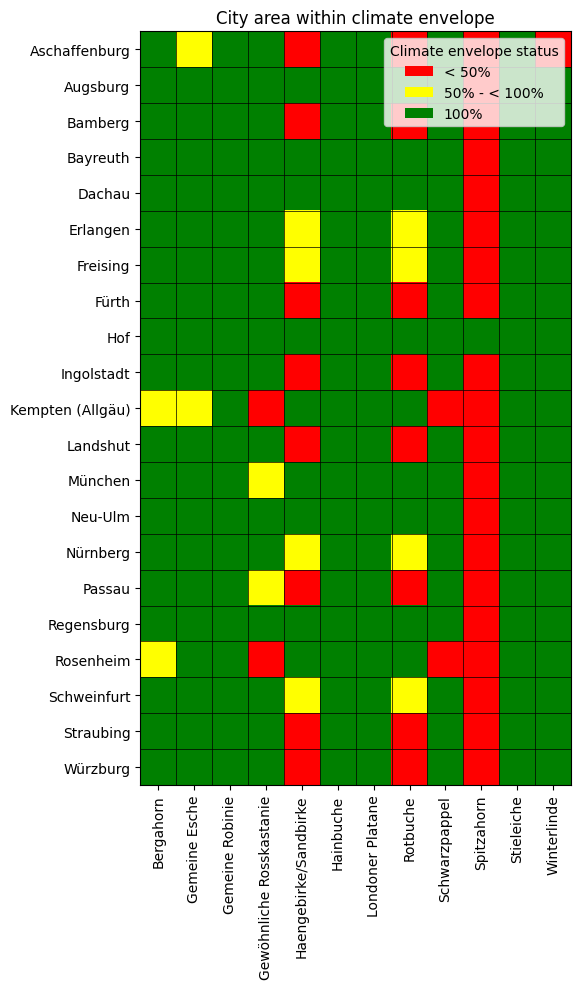

In [ ]:
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 1. Berechne für jede Kombination aus Stadt und Baumart den niedrigsten PCT_VALID-Wert über alle Zeitscheiben
df_min = df_results.groupby(["City", "Species"])["PCT_VALID"].min().reset_index()

# 2. Pivot-Tabelle erstellen: Zeilen = Städte, Spalten = Baumarten, Werte = minimaler PCT_VALID
pivot_df = df_min.pivot(index="City", columns="Species", values="PCT_VALID")

# 3. Erstelle eine Matrix mit Kategorien:
#    Kategorie 2 (grün): wenn der Wert exakt 100 ist
#    Kategorie 1 (gelb): wenn 50 <= Wert < 100
#    Kategorie 0 (rot): wenn Wert < 50
#    Fehlende Werte (NaN) werden mit -1 markiert.
category_matrix = np.zeros(pivot_df.shape, dtype=int)
for i in range(pivot_df.shape[0]):
    for j in range(pivot_df.shape[1]):
        value = pivot_df.iloc[i, j]
        if np.isnan(value):
            category_matrix[i, j] = -1  # Markierung für fehlende Werte
        elif value == 100:
            category_matrix[i, j] = 2
        elif value >= 50:
            category_matrix[i, j] = 1
        else:
            category_matrix[i, j] = 0

# 4. Definiere einen diskreten Colormap (Rot, Gelb, Grün)
cmap = mcolors.ListedColormap(['red', 'yellow', 'green'])
bounds = [-0.5, 0.5, 1.5, 2.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Für fehlende Werte (-1) erstellen wir eine Maske, sodass diese Zellen nicht eingefärbt werden.
masked_matrix = np.ma.masked_where(category_matrix == -1, category_matrix)

# 5. Erstelle den Heatmap-Plot
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(masked_matrix, cmap=cmap, norm=norm)

# Setze die Achsenbeschriftungen: x-Achse = Baumarten, y-Achse = Städte
ax.set_xticks(np.arange(len(pivot_df.columns)))
ax.set_xticklabels(pivot_df.columns, rotation=90)
ax.set_yticks(np.arange(len(pivot_df.index)))
ax.set_yticklabels(pivot_df.index)

# Optional: Gitterlinien einfügen, um die Zellen besser zu trennen
ax.set_xticks(np.arange(-0.5, len(pivot_df.columns), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(pivot_df.index), 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", bottom=False, left=False)

# Legende erstellen
legend_elements = [
    Patch(facecolor='red', label='< 50%'),
    Patch(facecolor='yellow', label='50% - < 100%'),
    Patch(facecolor='green', label='100%')
]
ax.legend(handles=legend_elements, loc='upper right', title='Climate envelope status')

ax.set_title("City area within climate envelope")
plt.tight_layout()
plt.show()


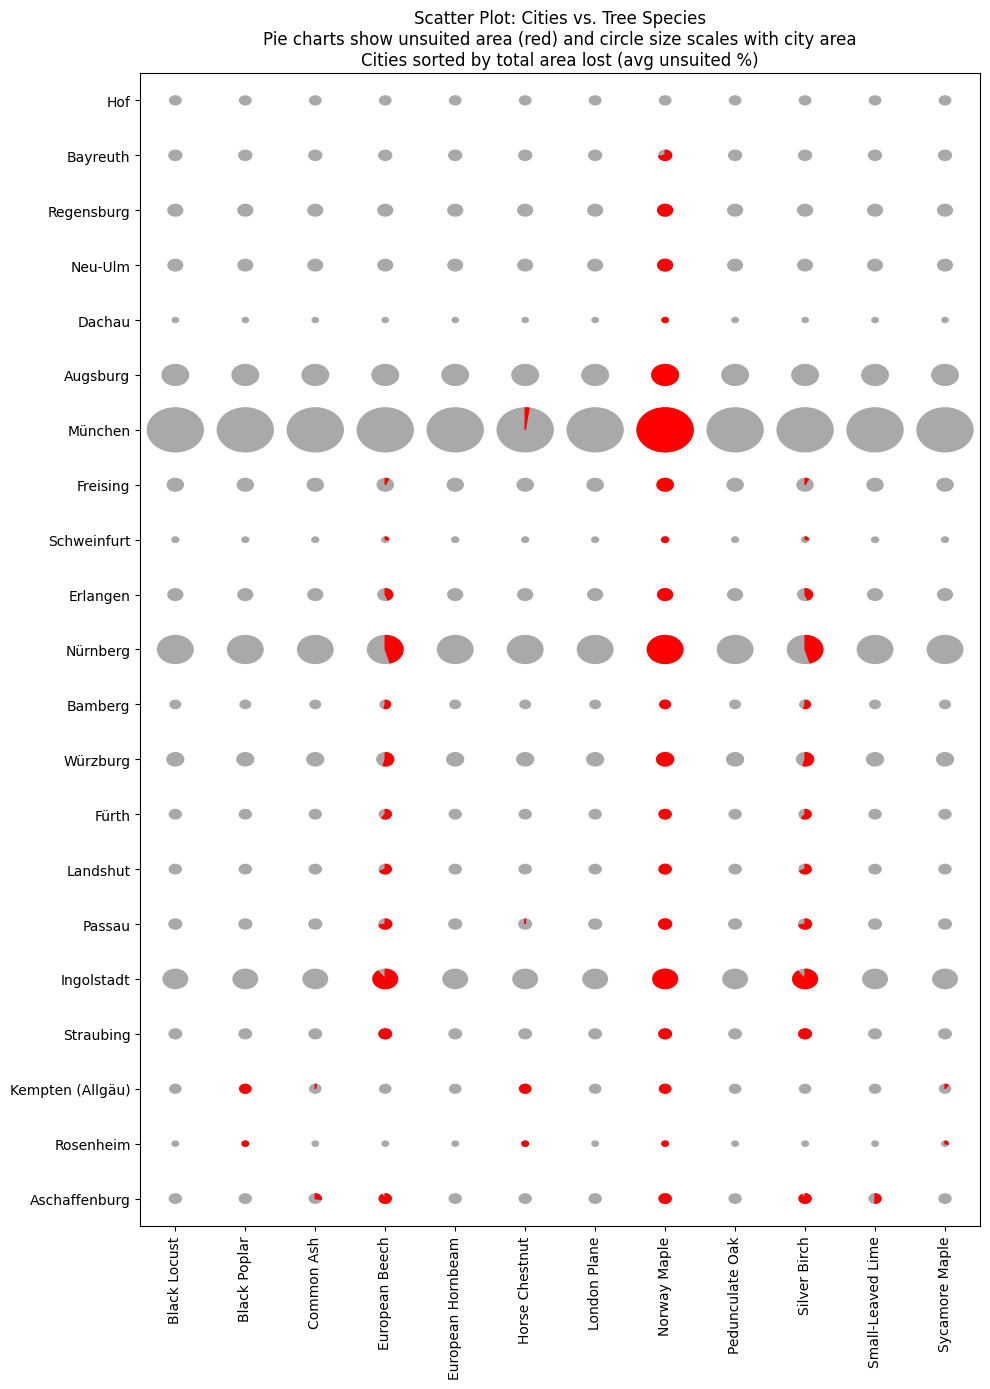

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge, Circle

df_results = pd.read_csv('results.csv')

species_mapping = {
    "Rotbuche": "European Beech",
    "Spitzahorn": "Norway Maple",
    "Bergahorn": "Sycamore Maple",
    "Gemeine Robinie": "Black Locust",
    "Gewöhnliche Rosskastanie": "Horse Chestnut",
    "Haengebirke/Sandbirke": "Silver Birch",
    "Hainbuche": "European Hornbeam",
    "Londoner Platane": "London Plane",
    "Schwarzpappel": "Black Poplar",
    "Stieleiche": "Pedunculate Oak",
    "Winterlinde": "Small-Leaved Lime",
    "Gemeine Esche": "Common Ash"
    # Add any additional mappings as needed.
}
df_results["Species"] = df_results["Species"].replace(species_mapping)
# ---------------------------
# 1. Data Preparation
# ---------------------------
# df_results contains the results from your earlier workflow.
# First, for each combination of City and Tree Species, we determine the minimal PCT_VALID over all time frames.
df_min = df_results.groupby(["City", "Species"])["PCT_VALID"].min().reset_index()

# Calculate the percentage of unsuited area (i.e. area lost) per cell.
df_min["Unsuitable"] = 100 - df_min["PCT_VALID"]

# Create a pivot table: rows = Cities, columns = Tree Species, values = Unsuitable (0 to 100)
pivot_unsuitable = df_min.pivot(index="City", columns="Species", values="Unsuitable")

# ---------------------------
# 2. Sorting Cities by Total Area Lost
# ---------------------------
# For each city, compute the average unsuited percentage (ignoring missing values).
city_loss = pivot_unsuitable.mean(axis=1)
# Sort cities by the average unsuited percentage in descending order
sorted_cities = city_loss.sort_values(ascending=False).index.tolist()

# Reorder the pivot table rows according to sorted cities.
pivot_unsuitable = pivot_unsuitable.loc[sorted_cities]
cities = pivot_unsuitable.index.tolist()
species = pivot_unsuitable.columns.tolist()

# ---------------------------
# 3. Retrieve City Areas for Scaling the Circle Size
# ---------------------------
# Load the shapefile ("VG250_GEM.shp")
gdf = gpd.read_file("VG250_GEM.shp")
gdf["ARS_0"] = gdf["ARS_0"].astype(str)

# Filter for the investigated cities (as in your previous code)
ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf["ARS_0"].isin(ars_list)].copy()

# To obtain valid area measurements, reproject to a metric CRS (EPSG:3857)
gdf_filtered_metric = gdf_filtered.to_crs(epsg=3857)
gdf_filtered_metric["area"] = gdf_filtered_metric["geometry"].area

# Create a dictionary mapping City name (assumed to be in the "GEN" column) to city area.
city_area = dict(zip(gdf_filtered_metric["GEN"], gdf_filtered_metric["area"]))

# Determine the maximum area for scaling purposes.
max_area = max(city_area.values())

# Define the maximum circle diameter (in plot coordinate units), e.g. 0.8.
max_diam = 0.8

# ---------------------------
# 4. Scatter Plot with Pie Chart Circles
# ---------------------------
fig, ax = plt.subplots(figsize=(10, 14))

# For each cell (combination City, Tree Species), draw a circle whose diameter scales with the city area,
# and inside the circle, plot a pie chart that shows the unsuited area percentage.
for i, city in enumerate(cities):
    for j, sp in enumerate(species):
        # Skip cells without data
        if pd.isna(pivot_unsuitable.loc[city, sp]):
            continue

        # Unsuited percentage (0 to 100)
        unsuited = pivot_unsuitable.loc[city, sp]
        # Fraction unsuited (between 0 and 1)
        f = unsuited / 100.0

        # Determine circle diameter based on the city area (linearly scaled)
        area_val = city_area.get(city, 0)
        diam = (area_val / max_area) * max_diam
        radius = diam / 2.0

        # Determine the position: x = index of tree species, y = index of city.
        x = j
        y = i

        # Draw the full circle in dark grey (representing the suitable area).
        base_circle = Circle((x, y), radius=radius, color='darkgrey', zorder=1)
        ax.add_patch(base_circle)

        # If the unsuited fraction is greater than 0, draw a red wedge (pie slice) showing the unsuited area.
        if f > 0:
            # Starting at 90° (top) and moving clockwise.
            # Matplotlib's Wedge draws counter-clockwise by default so we adjust the angles:
            wedge = Wedge((x, y), radius, theta1=90 - 360*f, theta2=90, color='red', zorder=2)
            ax.add_patch(wedge)

# ---------------------------
# 5. Axes and Labels
# ---------------------------
# Set axis limits so that all cells are visible.
ax.set_xlim(-0.5, len(species)-0.5)
ax.set_ylim(-0.5, len(cities)-0.5)

# Set ticks and labels for tree species (x-axis) and cities (y-axis)
ax.set_xticks(np.arange(len(species)))
ax.set_xticklabels(species, rotation=90)
ax.set_yticks(np.arange(len(cities)))
ax.set_yticklabels(cities)

ax.set_title("Scatter Plot: Cities vs. Tree Species\nPie charts show unsuited area (red) and circle size scales with city area\nCities sorted by total area lost (avg unsuited %)")
plt.tight_layout()
plt.show()


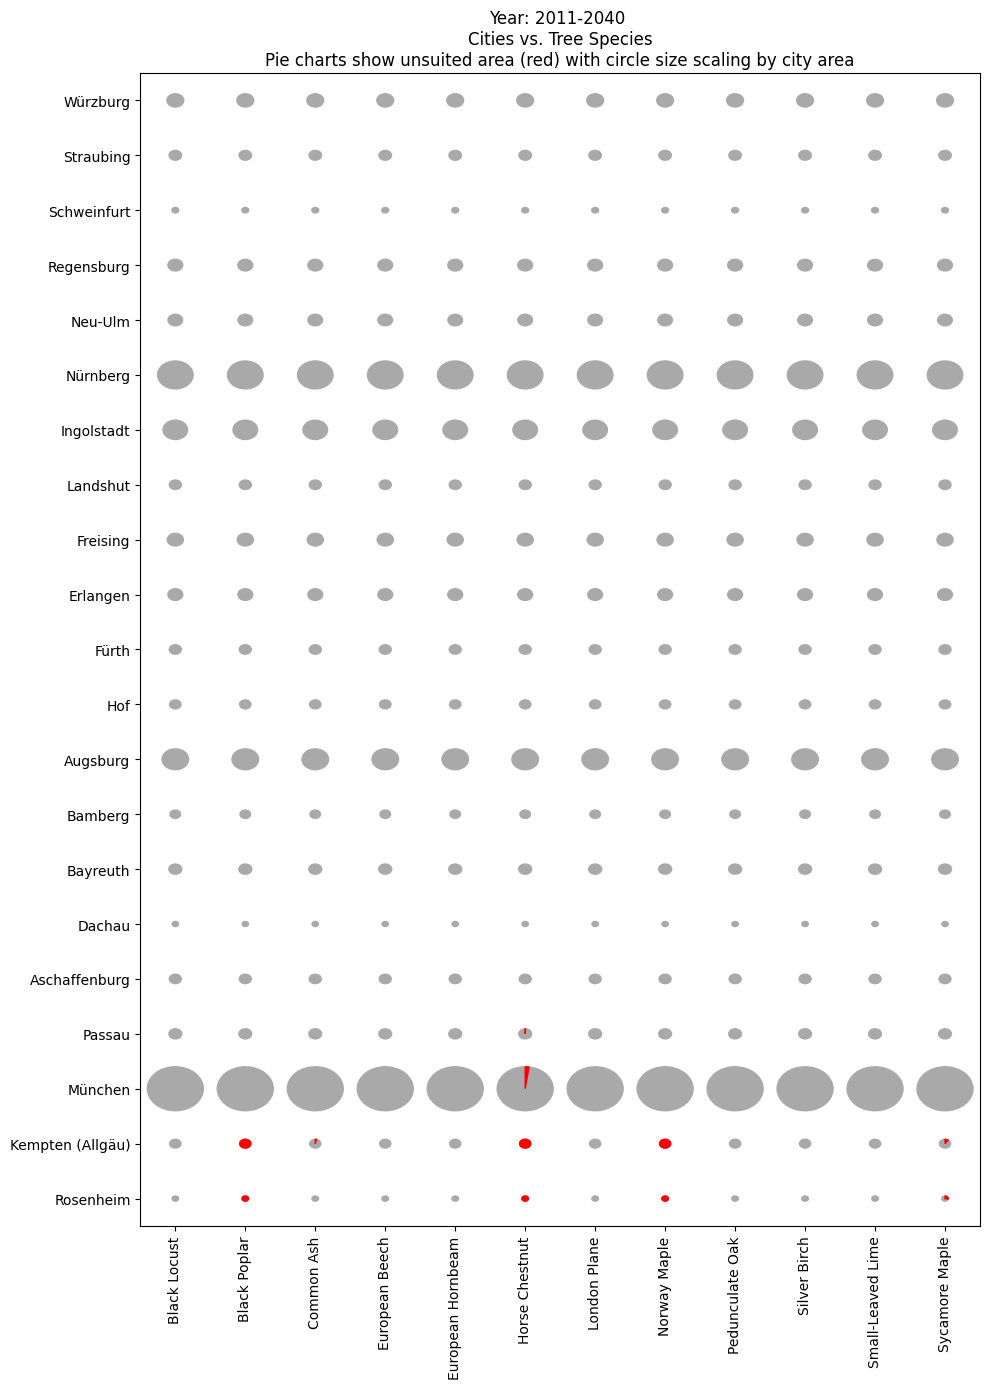

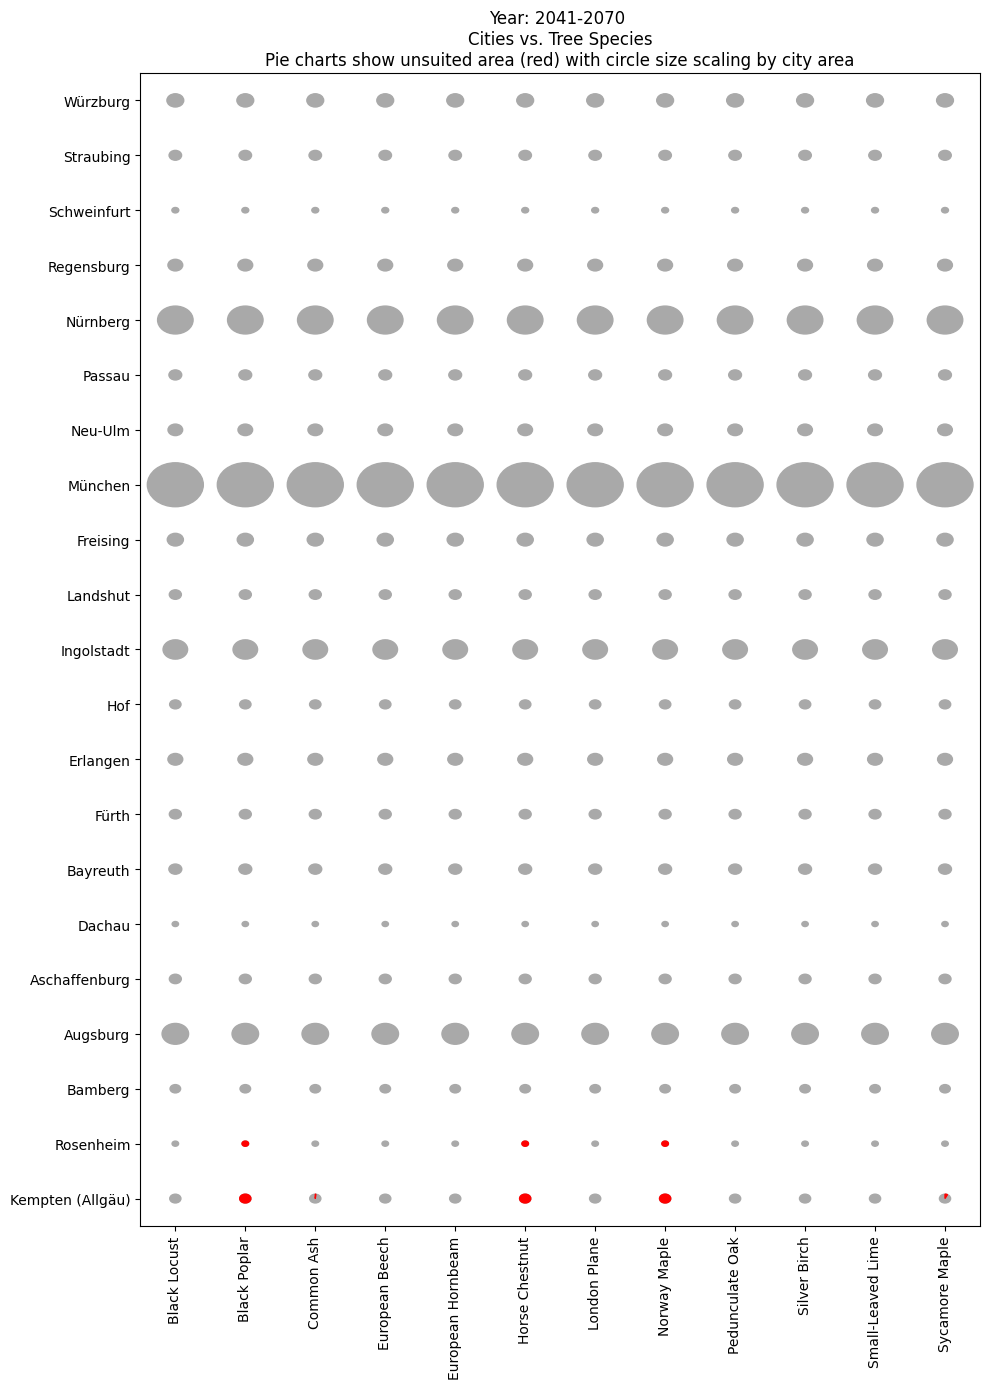

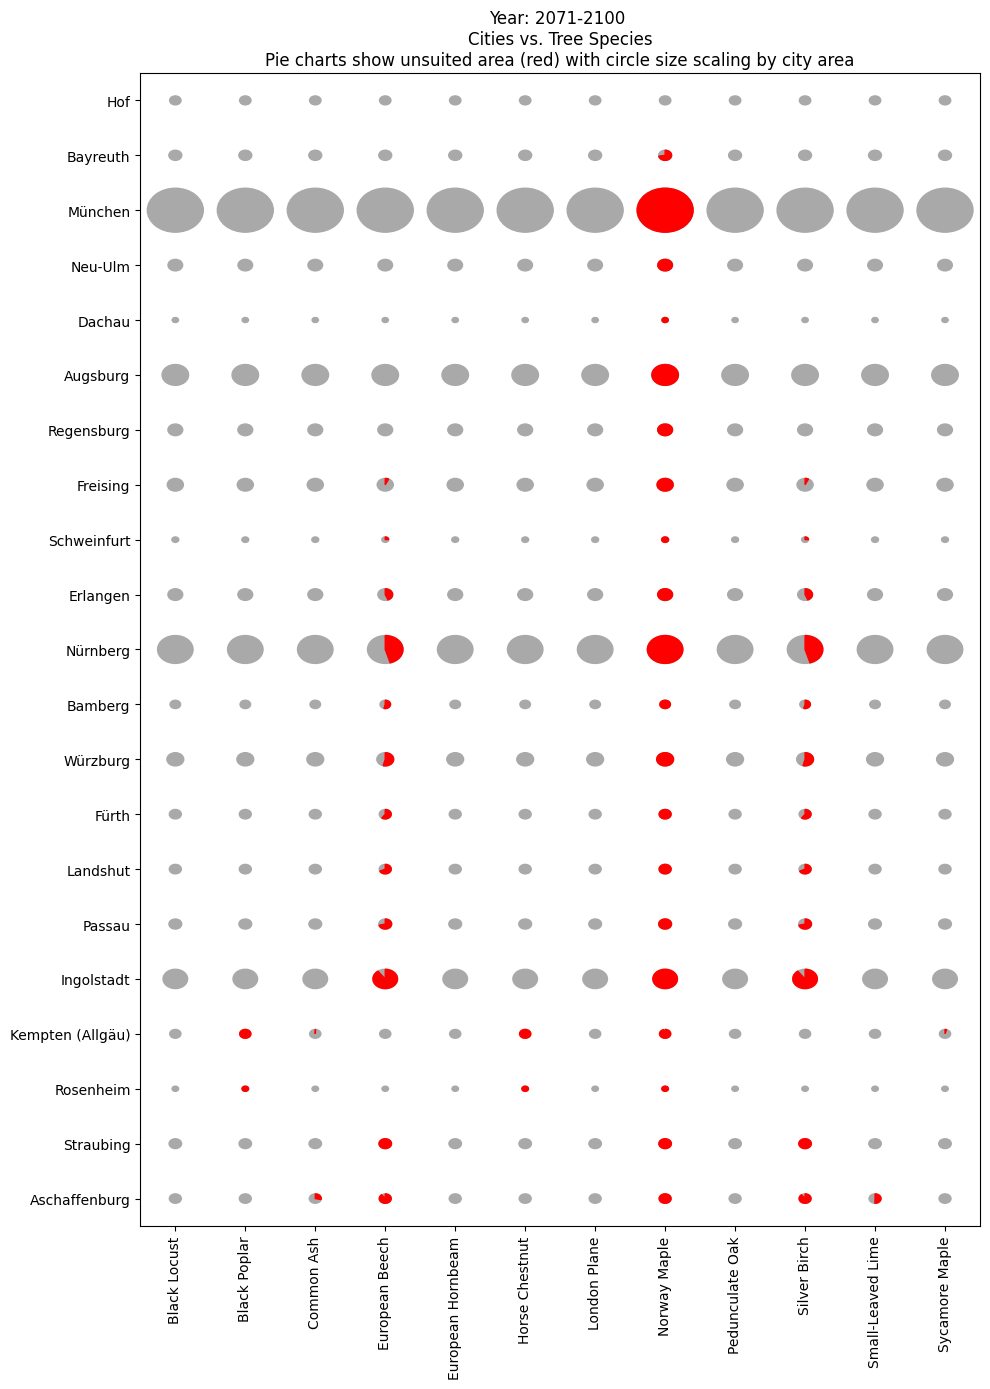

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge, Circle

# ---------------------------
# 0. Load and Preprocess the CSV Data
# ---------------------------
df_results = pd.read_csv('results.csv')

# Map species names from German to English
species_mapping = {
    "Rotbuche": "European Beech",
    "Spitzahorn": "Norway Maple",
    "Bergahorn": "Sycamore Maple",
    "Gemeine Robinie": "Black Locust",
    "Gewöhnliche Rosskastanie": "Horse Chestnut",
    "Haengebirke/Sandbirke": "Silver Birch",
    "Hainbuche": "European Hornbeam",
    "Londoner Platane": "London Plane",
    "Schwarzpappel": "Black Poplar",
    "Stieleiche": "Pedunculate Oak",
    "Winterlinde": "Small-Leaved Lime",
    "Gemeine Esche": "Common Ash"
    # Add any additional mappings as needed.
}
df_results["Species"] = df_results["Species"].replace(species_mapping)

# ---------------------------
# 1. Retrieve City Areas for Scaling the Circle Size
# ---------------------------
# Load the shapefile ("VG250_GEM.shp") and process city areas.
gdf = gpd.read_file("VG250_GEM.shp")
gdf["ARS_0"] = gdf["ARS_0"].astype(str)

ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf["ARS_0"].isin(ars_list)].copy()

# Reproject to a metric CRS (here EPSG:3857) for area calculations
gdf_filtered_metric = gdf_filtered.to_crs(epsg=3857)
gdf_filtered_metric["area"] = gdf_filtered_metric["geometry"].area

# Assume the city name is stored in the "GEN" column
city_area = dict(zip(gdf_filtered_metric["GEN"], gdf_filtered_metric["area"]))
max_area = max(city_area.values())
max_diam = 0.8  # Maximum circle diameter (in plot units)

# ---------------------------
# 2. Loop Over Each Time Step (Year) and Create a Plot
# ---------------------------
# The following code assumes that your CSV has a column named "Year".
# If your column is named differently, replace "Year" with the appropriate name.
unique_years = sorted(df_results['Time_Frame'].unique())

for year in unique_years:
    # Filter data for the current time step
    df_year = df_results[df_results["Time_Frame"] == year].copy()

    # For each combination of City and Species, take the minimal PCT_VALID value in that time step.
    df_min = df_year.groupby(["City", "Species"])["PCT_VALID"].min().reset_index()

    # Compute unsuited percentage (area lost) per cell.
    df_min["Unsuitable"] = 100 - df_min["PCT_VALID"]

    # Create pivot table (rows = Cities, columns = Tree Species, values = Unsuitable)
    pivot_unsuitable = df_min.pivot(index="City", columns="Species", values="Unsuitable")

    # Sort the cities by the average unsuited percentage (this order may change over time)
    city_loss = pivot_unsuitable.mean(axis=1)
    sorted_cities = city_loss.sort_values(ascending=False).index.tolist()
    pivot_unsuitable = pivot_unsuitable.loc[sorted_cities]
    cities = pivot_unsuitable.index.tolist()
    species = pivot_unsuitable.columns.tolist()

    # ---------------------------
    # 3. Create the Scatter Plot with Pie Chart Circles for this Year
    # ---------------------------
    fig, ax = plt.subplots(figsize=(10, 14))

    # Draw one circle for each combination of city and tree species
    for i, city in enumerate(cities):
        for j, sp in enumerate(species):
            # Skip if there is no data for this cell.
            if pd.isna(pivot_unsuitable.loc[city, sp]):
                continue

            # Unsuited percentage (0 to 100)
            unsuited = pivot_unsuitable.loc[city, sp]
            # Fraction unsuited (between 0 and 1)
            f = unsuited / 100.0

            # Determine circle diameter based on the city area (linearly scaled)
            area_val = city_area.get(city, 0)
            diam = (area_val / max_area) * max_diam
            radius = diam / 2.0

            # X = index of tree species; Y = index of city.
            x = j
            y = i

            # Draw the full circle in dark grey representing the suitable area.
            base_circle = Circle((x, y), radius=radius, color='darkgrey', zorder=1)
            ax.add_patch(base_circle)

            # If there is an unsuited fraction, overlay a red wedge (pie slice)
            if f > 0:
                # Wedge is drawn starting at 90° (top) moving clockwise.
                wedge = Wedge((x, y), radius, theta1=90 - 360*f, theta2=90, color='red', zorder=2)
                ax.add_patch(wedge)

    # Set axis limits so that all cells are visible.
    ax.set_xlim(-0.5, len(species) - 0.5)
    ax.set_ylim(-0.5, len(cities) - 0.5)

    # Set tick labels for tree species (x-axis) and cities (y-axis)
    ax.set_xticks(np.arange(len(species)))
    ax.set_xticklabels(species, rotation=90)
    ax.set_yticks(np.arange(len(cities)))
    ax.set_yticklabels(cities)

    ax.set_title(f"Year: {year} \nCities vs. Tree Species\nPie charts show unsuited area (red) with circle size scaling by city area")
    plt.tight_layout()
    plt.show()


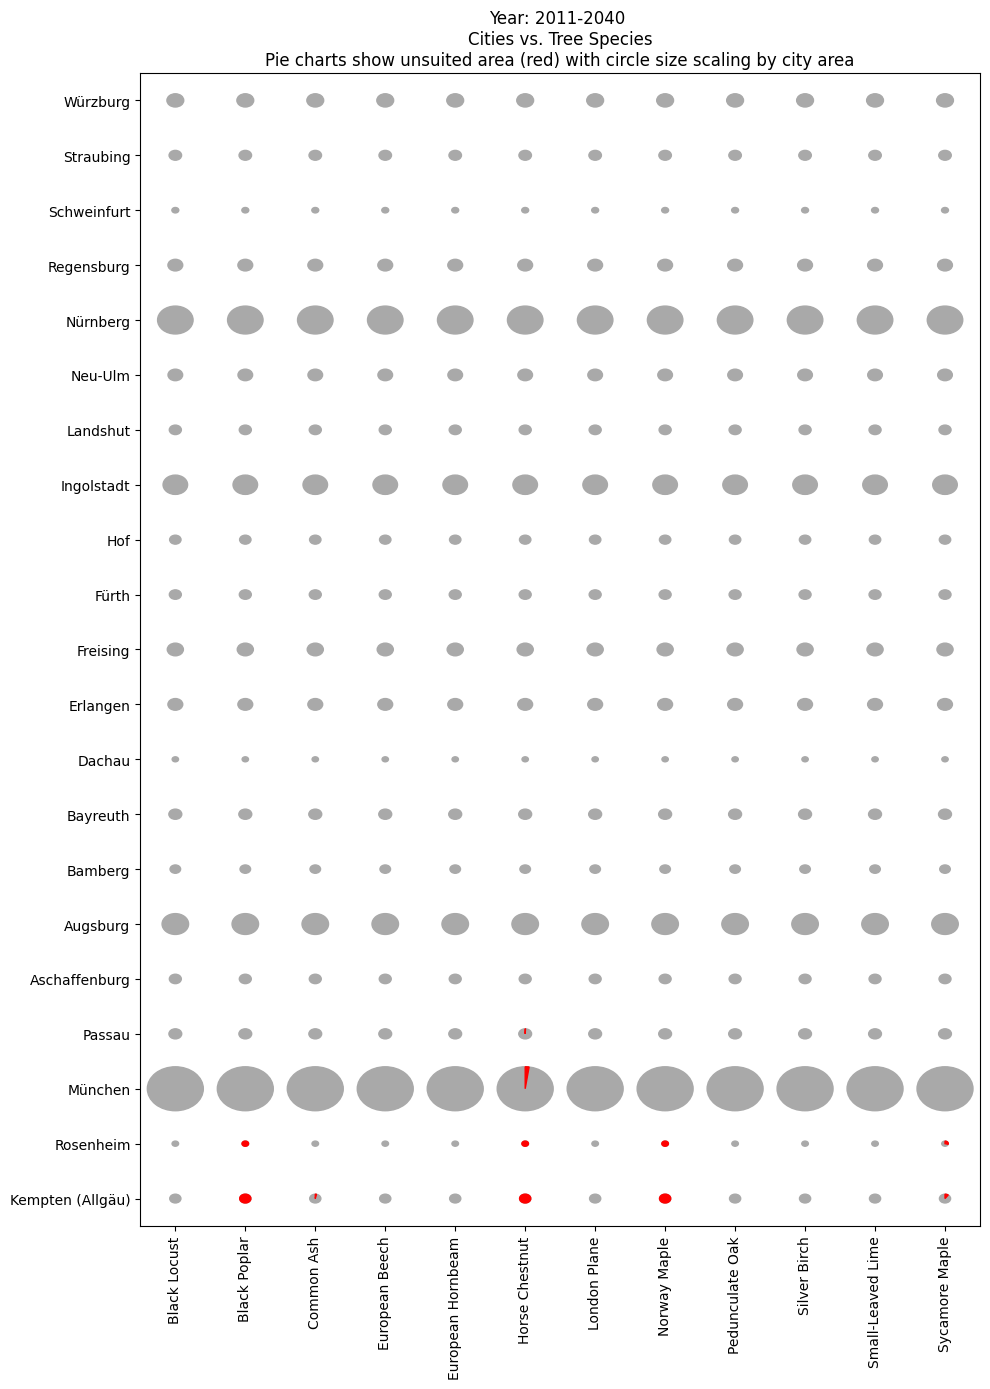

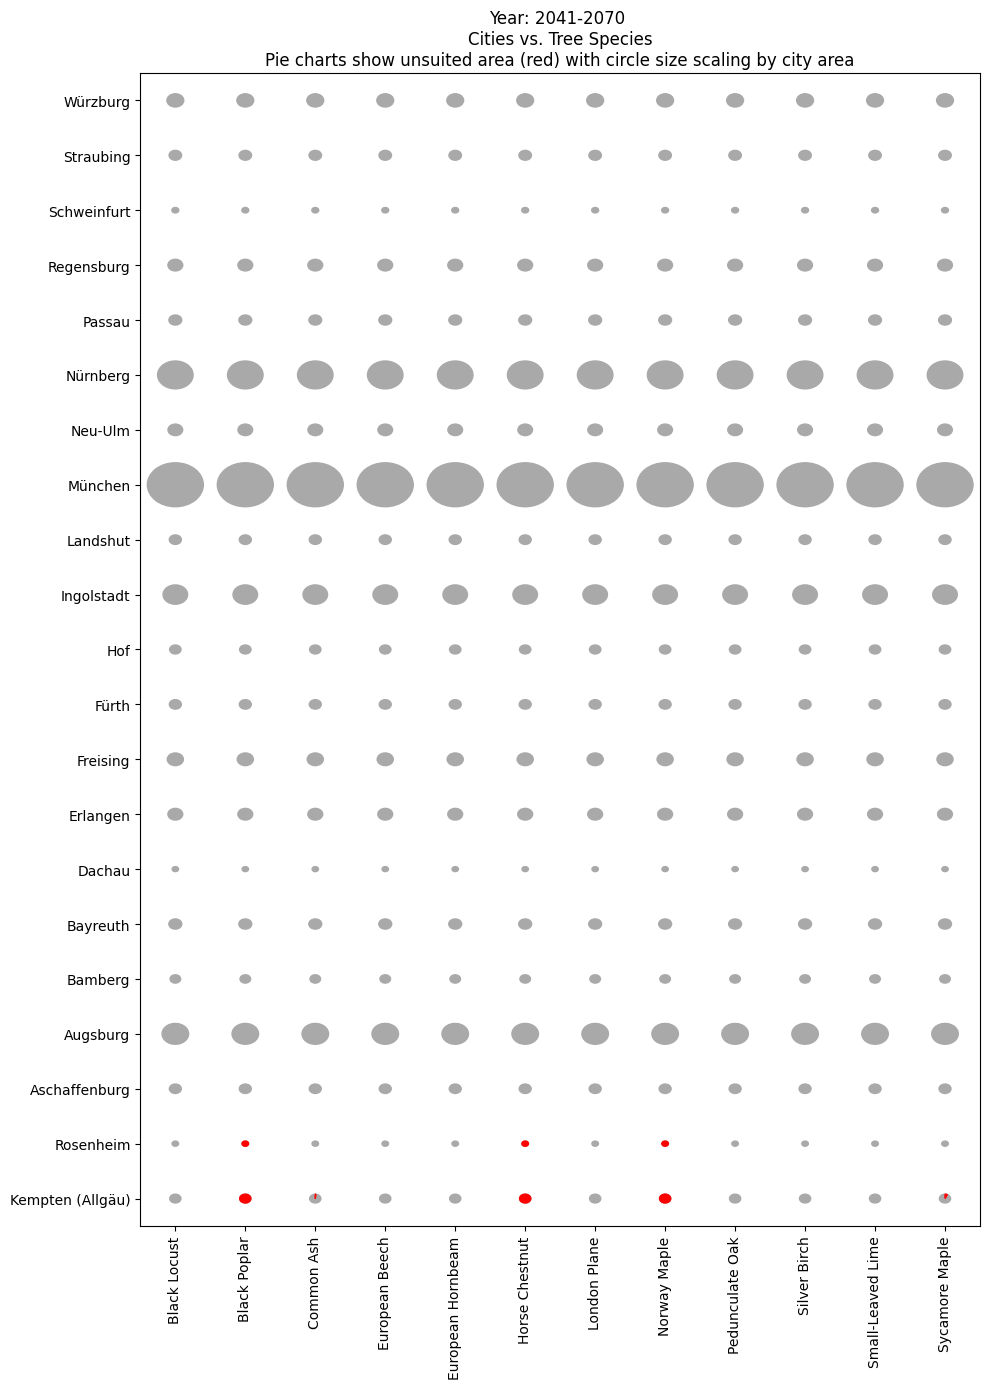

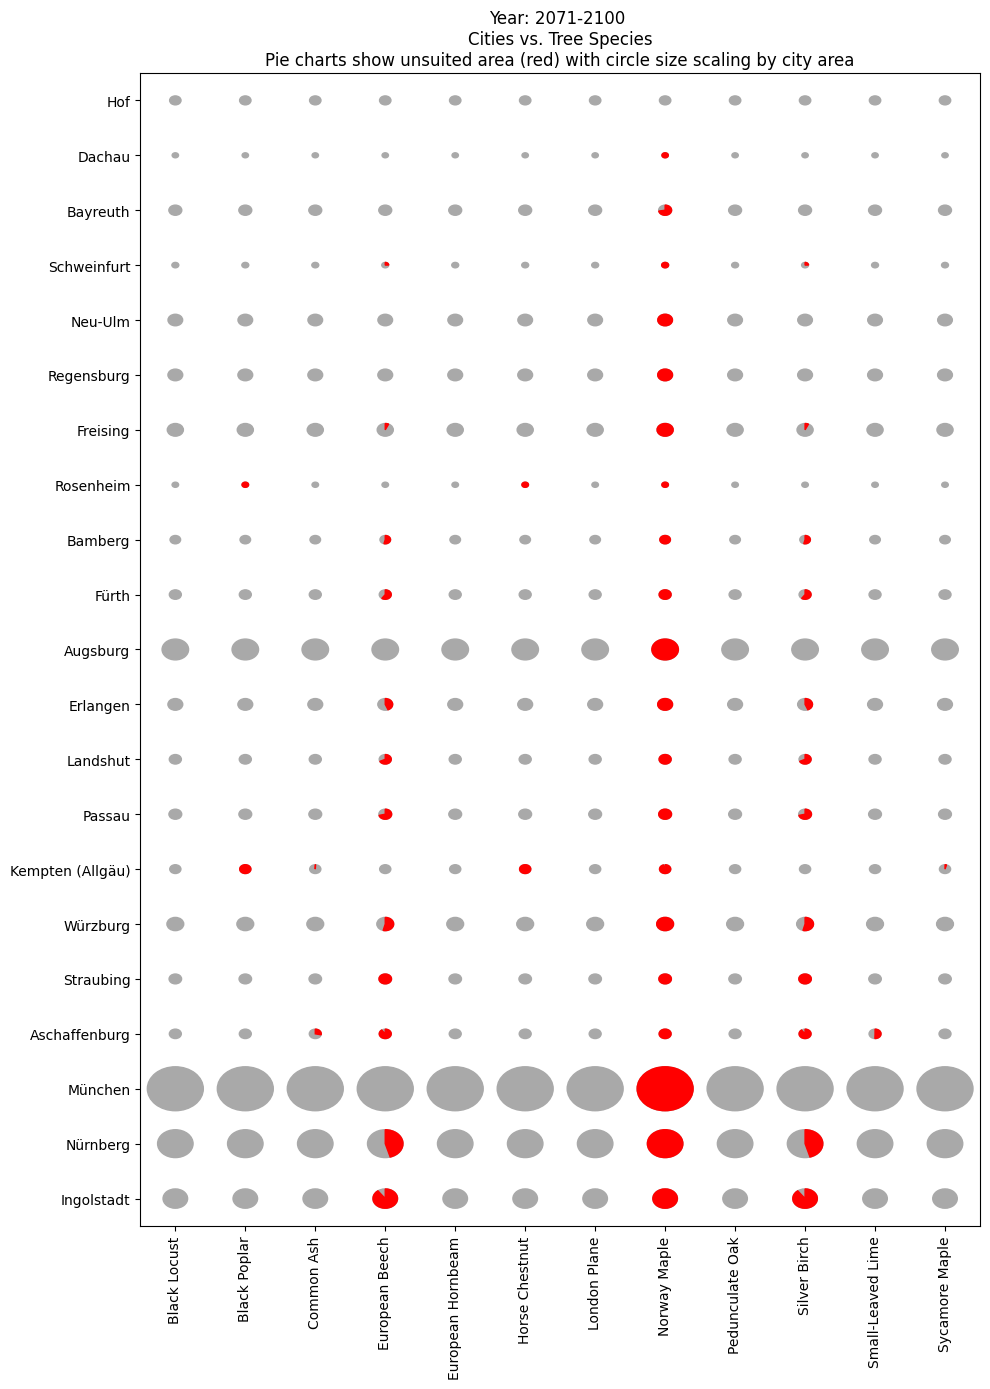

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge, Circle

# ---------------------------
# 0. Load and Preprocess the CSV Data
# ---------------------------
df_results = pd.read_csv('results.csv')

# Map species names from German to English
species_mapping = {
    "Rotbuche": "European Beech",
    "Spitzahorn": "Norway Maple",
    "Bergahorn": "Sycamore Maple",
    "Gemeine Robinie": "Black Locust",
    "Gewöhnliche Rosskastanie": "Horse Chestnut",
    "Haengebirke/Sandbirke": "Silver Birch",
    "Hainbuche": "European Hornbeam",
    "Londoner Platane": "London Plane",
    "Schwarzpappel": "Black Poplar",
    "Stieleiche": "Pedunculate Oak",
    "Winterlinde": "Small-Leaved Lime",
    "Gemeine Esche": "Common Ash"
    # Füge ggf. weitere Zuordnungen hinzu.
}
df_results["Species"] = df_results["Species"].replace(species_mapping)

# ---------------------------
# 1. Retrieve City Areas for Scaling the Circle Size
# ---------------------------
# Lade das Shapefile ("VG250_GEM.shp") und verarbeite die Stadtflächen.
gdf = gpd.read_file("VG250_GEM.shp")
gdf["ARS_0"] = gdf["ARS_0"].astype(str)

ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf["ARS_0"].isin(ars_list)].copy()

# Reprojiziere in ein metrisches Koordinatensystem (hier EPSG:3857) für Flächenberechnungen.
gdf_filtered_metric = gdf_filtered.to_crs(epsg=3857)
gdf_filtered_metric["area"] = gdf_filtered_metric["geometry"].area

# Annahme: Der Stadtname befindet sich in der Spalte "GEN".
city_area = dict(zip(gdf_filtered_metric["GEN"], gdf_filtered_metric["area"]))
max_area = max(city_area.values())
max_diam = 0.8  # Maximale Kreis-Durchmesser (in Plot-Einheiten)

# ---------------------------
# 2. Loop Over Each Time Step (Year) and Create a Plot
# ---------------------------
unique_years = sorted(df_results['Time_Frame'].unique())

for year in unique_years:
    # Filtere Daten für das aktuelle Zeitintervall
    df_year = df_results[df_results["Time_Frame"] == year].copy()

    # Für jede Kombination aus Stadt und Baumart: benutze den minimalen PCT_VALID-Wert in diesem Zeitintervall.
    df_min = df_year.groupby(["City", "Species"])["PCT_VALID"].min().reset_index()

    # Berechne den unsuitierten Anteil (als Prozentzahl der verlorenen Fläche) pro Zelle.
    df_min["Unsuitable"] = 100 - df_min["PCT_VALID"]

    # Erstelle eine Pivot-Tabelle (Zeilen = Städte, Spalten = Baumarten, Werte = Unsuitable)
    pivot_unsuitable = df_min.pivot(index="City", columns="Species", values="Unsuitable")

    # ---------------------------
    # 2a. Sortiere Städte basierend auf der aggregierten Verlustfläche
    # ---------------------------
    # Hier multiplizieren wir für jede vorhandene Zelle den unsuitierten Anteil
    # (als Bruch, also Unsuitable/100) mit der tatsächlichen Stadtfläche (city_area).
    # Anschließend summieren wir diese Flächen für jede Stadt.
    lost_areas = {}
    for city in pivot_unsuitable.index:
        # Ziehe nur die vorhandenen (nicht-NaN) Werte heran und wandle in Bruch um.
        f_values = pivot_unsuitable.loc[city].dropna() / 100.0
        # Die echte Stadtfläche laut Shapefile (gdf_filtered_metric["area"])
        area_val = city_area.get(city, 0)
        # Für jede Baumart: Verlust = (Unsuitable-Anteil) * Stadtfläche.
        # Hier wird über alle vorhandenen Baumarten aufsummiert.
        lost_area = (f_values * area_val).sum()
        lost_areas[city] = lost_area

    # Sortiere die Städte absteigend nach der berechneten Gesamtverlustfläche.
    sorted_cities = sorted(lost_areas, key=lambda x: lost_areas[x], reverse=True)
    pivot_unsuitable = pivot_unsuitable.loc[sorted_cities]
    cities = pivot_unsuitable.index.tolist()
    species = pivot_unsuitable.columns.tolist()

    # ---------------------------
    # 3. Erstelle den Scatter-Plot mit Kreis-Pie-Charts für das aktuelle Jahr
    # ---------------------------
    fig, ax = plt.subplots(figsize=(10, 14))

    for i, city in enumerate(cities):
        for j, sp in enumerate(species):
            # Überspringe Zellen ohne Daten.
            if pd.isna(pivot_unsuitable.loc[city, sp]):
                continue

            # Unsuited percentage (0 bis 100)
            unsuited = pivot_unsuitable.loc[city, sp]
            # Bruch unsuited (zwischen 0 und 1)
            f = unsuited / 100.0

            # Berechne den Plot-Kreis-Durchmesser basierend auf der Stadtfläche (linear skaliert)
            area_val = city_area.get(city, 0)
            diam = (area_val / max_area) * max_diam
            radius = diam / 2.0

            # Position: x = Index der Baumart, y = Index der Stadt.
            x = j
            y = i

            # Zeichne den Basis-Kreis (in dunkelgrau) als Grundlage.
            base_circle = Circle((x, y), radius=radius, color='darkgrey', zorder=1)
            ax.add_patch(base_circle)

            # Falls ein unsuitierter Anteil vorliegt, überlagere einen roten Wedge (Kuchenstück)
            if f > 0:
                # Der Wedge wird ab 90° (oben) im Uhrzeigersinn gezeichnet.
                wedge = Wedge((x, y), radius, theta1=90 - 360*f, theta2=90, color='red', zorder=2)
                ax.add_patch(wedge)

    # Setze Achsen-Limits, damit alle Zellen sichtbar sind.
    ax.set_xlim(-0.5, len(species) - 0.5)
    ax.set_ylim(-0.5, len(cities) - 0.5)

    # Setze Tick-Labels für Baumarten (x-Achse) und Städte (y-Achse)
    ax.set_xticks(np.arange(len(species)))
    ax.set_xticklabels(species, rotation=90)
    ax.set_yticks(np.arange(len(cities)))
    ax.set_yticklabels(cities)

    ax.set_title(f"Year: {year} \nCities vs. Tree Species\nPie charts show unsuited area (red) with circle size scaling by city area")
    plt.tight_layout()
    plt.show()



           City                   Species Time_Frame  TOTAL_PIXELS  \
0    Ingolstadt                  Rotbuche  2011-2040           236   
1    Ingolstadt                  Rotbuche  2041-2070           236   
2    Ingolstadt                  Rotbuche  2071-2100           236   
3    Ingolstadt                Spitzahorn  2011-2040           236   
4    Ingolstadt                Spitzahorn  2041-2070           236   
..          ...                       ...        ...           ...   
751     Neu-Ulm           Gemeine Robinie  2041-2070           143   
752     Neu-Ulm           Gemeine Robinie  2071-2100           143   
753     Neu-Ulm  Gewöhnliche Rosskastanie  2011-2040           143   
754     Neu-Ulm  Gewöhnliche Rosskastanie  2041-2070           143   
755     Neu-Ulm  Gewöhnliche Rosskastanie  2071-2100           143   

     VALID_PIXELS   PCT_VALID  
0             236  100.000000  
1             236  100.000000  
2              24   10.169492  
3             236  100.000000  

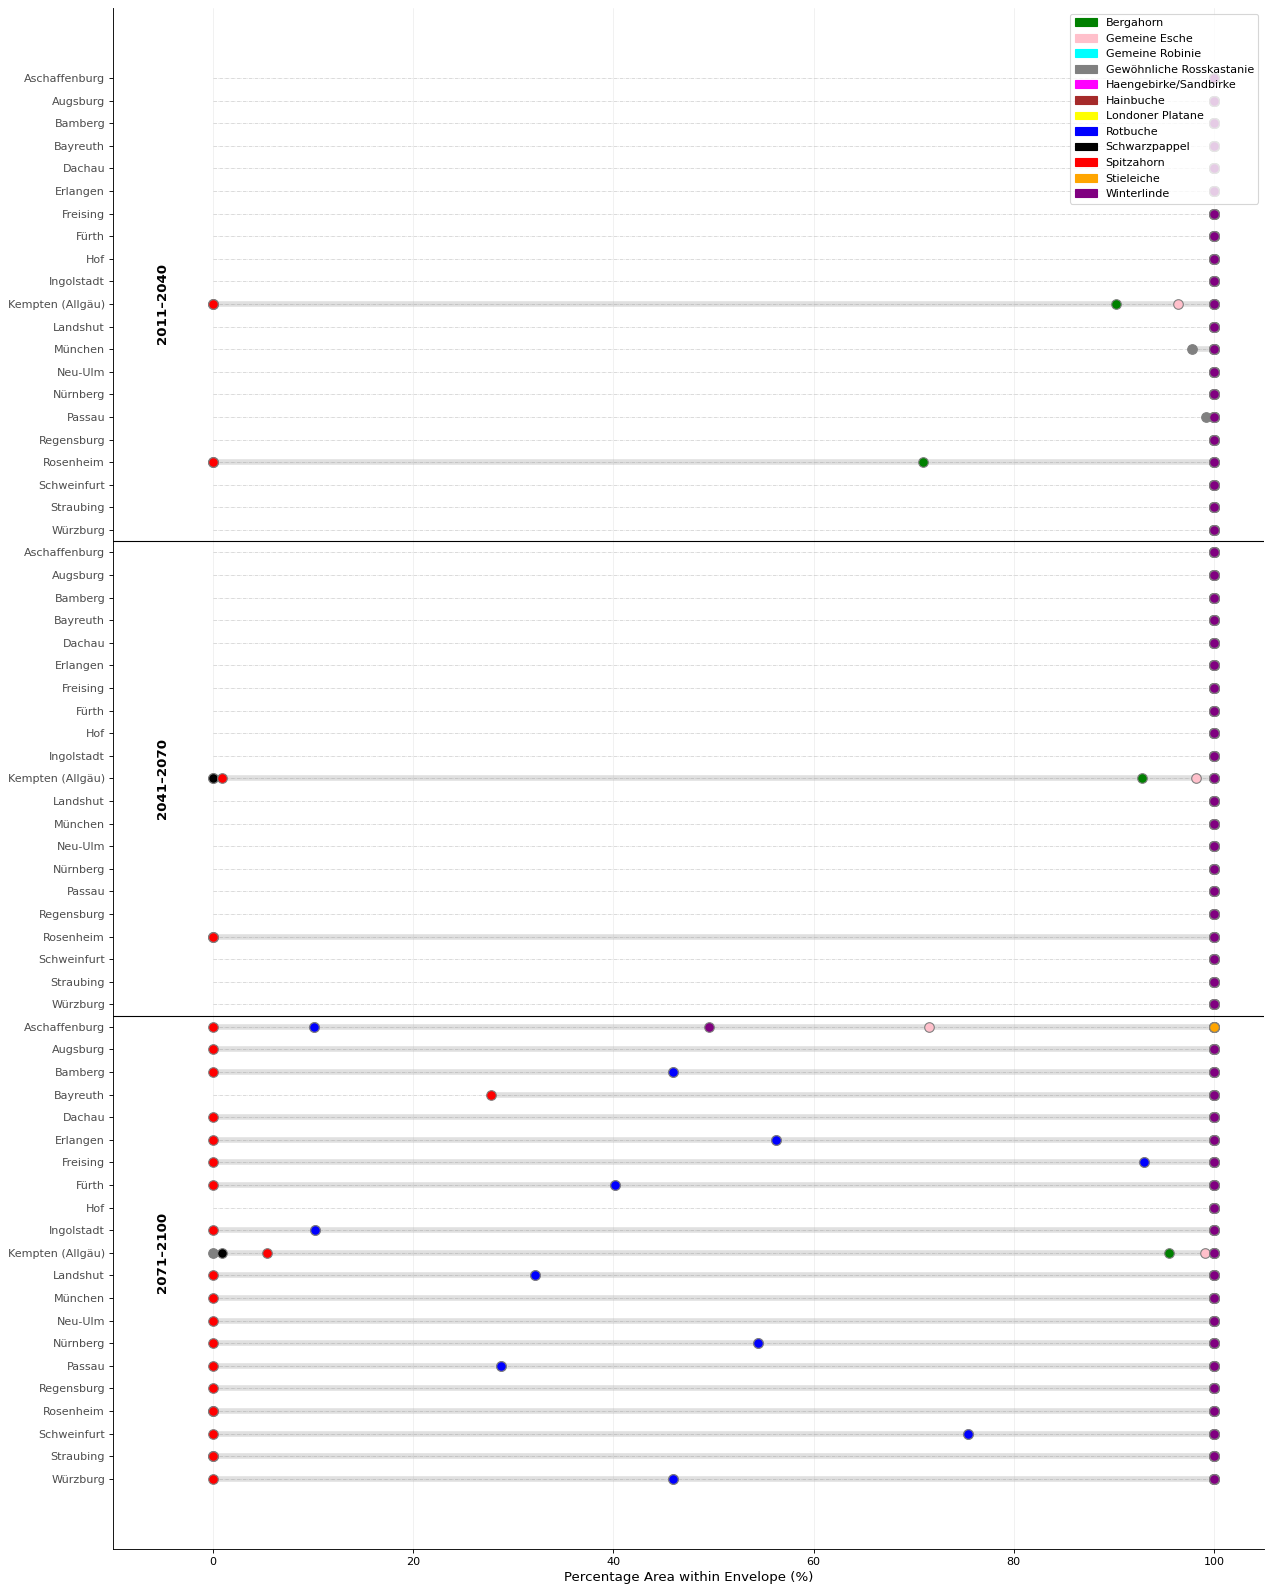

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# -----------------------------------------------------------------
# 1. Set up the mapping of (species, time_frame) to raster file paths
# -----------------------------------------------------------------
raster_files = {
    ('Rotbuche', '2011-2040'): "Rotbuche_2011-2040.tif",
    ('Rotbuche', '2041-2070'): "Rotbuche_2041-2070.tif",
    ('Rotbuche', '2071-2100'): "Rotbuche_2071-2100.tif",
    ('Spitzahorn', '2011-2040'): "Spitzahorn_2011-2040.tif",
    ('Spitzahorn', '2041-2070'): "Spitzahorn_2041-2070.tif",
    ('Spitzahorn', '2071-2100'): "Spitzahorn_2071-2100.tif",
    ('Bergahorn', '2011-2040'): "Bergahorn_2011-2040.tif",
    ('Bergahorn', '2041-2070'): "Bergahorn_2041-2070.tif",
    ('Bergahorn', '2071-2100'): "Bergahorn_2071-2100.tif",
    ('Stieleiche', '2011-2040'): "Stieleiche_2011-2040.tif",
    ('Stieleiche', '2041-2070'): "Stieleiche_2041-2070.tif",
    ('Stieleiche', '2071-2100'): "Stieleiche_2071-2100.tif",
    ('Winterlinde', '2011-2040'): "Winterlinde_2011-2040.tif",
    ('Winterlinde', '2041-2070'): "Winterlinde_2041-2070.tif",
    ('Winterlinde', '2071-2100'): "Winterlinde_2071-2100.tif",
    ('Haengebirke/Sandbirke', '2011-2040'): "Haengebirke_Sandbirke_2011-2040.tif",
    ('Haengebirke/Sandbirke', '2041-2070'): "Haengebirke_Sandbirke_2041-2070.tif",
    ('Haengebirke/Sandbirke', '2071-2100'): "Haengebirke_Sandbirke_2071-2100.tif",
    ('Schwarzpappel', '2011-2040'): "Schwarz_pappel_2011-2040.tif",
    ('Schwarzpappel', '2041-2070'): "Schwarz_pappel_2041-2070.tif",
    ('Schwarzpappel', '2071-2100'): "Schwarz_pappel_2071-2100.tif",
    ('Hainbuche', '2011-2040'): "Hainbuche_2011-2040.tif",
    ('Hainbuche', '2041-2070'): "Hainbuche_2041-2070.tif",
    ('Hainbuche', '2071-2100'): "Hainbuche_2071-2100.tif",
    ('Gemeine Esche', '2011-2040'): "Gemeine_Esche_2011-2040.tif",
    ('Gemeine Esche', '2041-2070'): "Gemeine_Esche_2041-2070.tif",
    ('Gemeine Esche', '2071-2100'): "Gemeine_Esche_2071-2100.tif",
    ('Londoner Platane', '2011-2040'): "nh2011_Londoner_Platane.tif",
    ('Londoner Platane', '2041-2070'): "nh2041_Londoner_Platane.tif",
    ('Londoner Platane', '2071-2100'): "nh2071_Londoner_Platane.tif",
    ('Gemeine Robinie', '2011-2040'): "Gemeine_Robinie_2011-2040.tif",
    ('Gemeine Robinie', '2041-2070'): "Gemeine_Robinie_2041-2070.tif",
    ('Gemeine Robinie', '2071-2100'): "Gemeine_Robinie_2071-2100.tif",
    ('Gewöhnliche Rosskastanie', '2011-2040'): "nh2011_Gewoehnliche_Rosskastanie.tif",
    ('Gewöhnliche Rosskastanie', '2041-2070'): "nh2041_Gewoehnliche_Rosskastanie.tif",
    ('Gewöhnliche Rosskastanie', '2071-2100'): "nh2071_Gewoehnliche_Rosskastanie.tif"
}

# -----------------------------------------------------------------
# 2. Load the shapefile and filter by your ARS list (if needed)
#    We'll use the "GEN" column for city names.
# -----------------------------------------------------------------
shapefile_path = "VG250_GEM.shp"
gdf = gpd.read_file(shapefile_path)

ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf['ARS_0'].isin(ars_list)].copy()

# -----------------------------------------------------------------
# 3. Define a function to compute pixel metrics for a given polygon and raster.
# -----------------------------------------------------------------
def get_polygon_metrics(raster_path, polygon):
    with rasterio.open(raster_path) as src:
        # Extract the raster values over the polygon's bounding box.
        out_image, out_transform = mask(src, [polygon.__geo_interface__],
                                        crop=True, all_touched=True, filled=True)
        data_filled = out_image[0]  # first band

        # Create a geometry mask based solely on the polygon.
        poly_mask = geometry_mask([polygon.__geo_interface__],
                                  out_shape=data_filled.shape,
                                  transform=out_transform,
                                  invert=True)
        # Count total pixels inside the polygon (using the geometry mask)
        total_pixels = np.sum(poly_mask)
        # Count valid pixels (inside the polygon with value > 0)
        valid_pixels = np.sum((data_filled > 0) & poly_mask)
        pct_valid = (valid_pixels / total_pixels * 100) if total_pixels > 0 else 0

    return int(total_pixels), int(valid_pixels), pct_valid

# -----------------------------------------------------------------
# 4. Reproject the shapefile to the CRS of the rasters.
#    Here, we assume all rasters share the same CRS.
# -----------------------------------------------------------------
# Get the CRS from one of the rasters:
first_raster = list(raster_files.values())[0]
with rasterio.open(first_raster) as src:
    raster_crs = src.crs

if gdf_filtered.crs != raster_crs:
    gdf_filtered = gdf_filtered.to_crs(raster_crs)

# -----------------------------------------------------------------
# 5. Loop over each city (using the "GEN" column for names)
#    and each raster (species and time_frame) to compute metrics.
# -----------------------------------------------------------------
results = []
for idx, row in gdf_filtered.iterrows():
    city_name = row["GEN"]
    polygon = row.geometry
    for (species, time_frame), raster_file in raster_files.items():
        total_pixels, valid_pixels, pct_valid = get_polygon_metrics(raster_file, polygon)
        results.append({
            "City": city_name,
            "Species": species,
            "Time_Frame": time_frame,
            "TOTAL_PIXELS": total_pixels,
            "VALID_PIXELS": valid_pixels,
            "PCT_VALID": pct_valid
        })

df_results = pd.DataFrame(results)
print(df_results)
df_results.to_csv('results.csv', index=False)

# -----------------------------------------------------------------
# 6. Plotting: Prepare data and create a horizontal dot plot
#    comparing the percentage valid pixels for each city.
# -----------------------------------------------------------------
# Pivot the data for each time frame so that rows are cities and columns are tree species.
def pivot_time_frame(df, time_frame):
    group = df[df['Time_Frame'] == time_frame].pivot(index='City', columns='Species', values='PCT_VALID').reset_index()
    return group

group1 = pivot_time_frame(df_results, '2011-2040')
group2 = pivot_time_frame(df_results, '2041-2070')
group3 = pivot_time_frame(df_results, '2071-2100')

# Compute uncertainty margins dynamically over all species columns.
for group in [group1, group2, group3]:
    species_cols = [col for col in group.columns if col != 'City']
    group['Uncertainty_Min'] = group[species_cols].min(axis=1)
    group['Uncertainty_Max'] = group[species_cols].max(axis=1)

# Record the number of rows per group.
n1 = group1.shape[0]
n2 = group2.shape[0]
n3 = group3.shape[0]

# Concatenate the groups in order (earliest time frame first).
df_all = pd.concat([group1, group2, group3], ignore_index=True)

# Create y positions for each row and get city labels.
y_positions = np.arange(df_all.shape[0])
ytick_labels = df_all['City'].tolist()

# ----- Plotting -----
fig, ax = plt.subplots(figsize=(16, 20), dpi=80)

# Draw horizontal guide lines for each row (x-axis from 0 to 100%).
ax.hlines(y=y_positions, xmin=0, xmax=100, color='gray', alpha=0.5, linewidth=0.5, linestyles='dashdot')

# Draw thicker uncertainty margin lines behind the dots.
for i, row in df_all.iterrows():
    ax.hlines(y=i, xmin=row['Uncertainty_Min'], xmax=row['Uncertainty_Max'],
              color='lightgrey', linewidth=5, alpha=0.7, zorder=1)

# Define colors for every species.
colors = {
    'Rotbuche': 'blue',
    'Spitzahorn': 'red',
    'Bergahorn': 'green',
    'Stieleiche': 'orange',
    'Winterlinde': 'purple',
    'Hainbuche': 'brown',
    'Gemeine Esche': 'pink',
    'Gemeine Robinie': 'cyan',
    'Haengebirke/Sandbirke': 'magenta',
    'Schwarzpappel': 'black',
    'Londoner Platane': 'yellow',
    'Gewöhnliche Rosskastanie': 'gray'
}

# Determine species columns (all columns except 'City', 'Uncertainty_Min', and 'Uncertainty_Max').
species_columns = [col for col in df_all.columns if col not in ['City', 'Uncertainty_Min', 'Uncertainty_Max']]

# Plot dots for each species for every row.
for i, row in df_all.iterrows():
    for species in species_columns:
        ax.scatter(row[species], i, s=75, color=colors.get(species, 'black'),
                   edgecolors='gray', zorder=3)

# Set y-ticks to show city names.
ax.set_yticks(y_positions)
ax.set_yticklabels(ytick_labels, fontdict={'horizontalalignment': 'right'}, alpha=0.7)

# Invert the y-axis so that the earliest group appears on top.
ax.invert_yaxis()

# Add horizontal separator lines between time frame groups.
sep1 = n1 - 0.5
sep2 = n1 + n2 - 0.5
ax.axhline(y=sep1, color='black', linewidth=1)
ax.axhline(y=sep2, color='black', linewidth=1)

# Add period labels next to each group.
center_group1 = (n1 - 1) / 2
center_group2 = n1 + (n2 - 1) / 2
center_group3 = n1 + n2 + (n3 - 1) / 2
x_label = -5  # adjust x offset for period labels

ax.text(x_label, center_group1, "2011–2040", ha='center', va='center',
        rotation=90, fontsize=12, fontweight='bold')
ax.text(x_label, center_group2, "2041–2070", ha='center', va='center',
        rotation=90, fontsize=12, fontweight='bold')
ax.text(x_label, center_group3, "2071–2100", ha='center', va='center',
        rotation=90, fontsize=12, fontweight='bold')

# Set x-axis label and limits.
ax.set_xlabel('Percentage Area within Envelope (%)', fontsize=12)
ax.set_xlim(-10, 105)

# Build a legend with a patch for each species.
patches = [mpatches.Patch(color=colors[sp], label=sp) for sp in species_columns]
plt.legend(handles=patches, loc='upper right')

# Remove top and right spines for a cleaner look.
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add light vertical grid lines.
ax.grid(axis='x', alpha=0.3, linewidth=0.5)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Specify the path to your CSV file
csv_path = "baumkataster_stadt_wuerzburg.csv"  # Adjust the filename as needed

# Load the CSV file into a DataFrame, using the delimiter ';' and handling bad lines with a warning
df = pd.read_csv(csv_path, delimiter=';', on_bad_lines='warn')

# Count total trees in the cadaster
total_trees = len(df)

# Define the specific tree species (inside the climate envelope) to count.
# Adjust the names to match exactly those in the "Baumart deutsch" column.
tree_species = [
    "Spitz-Ahorn",
    "SPITZ-AHORN SCHWEDLERI",
    "SPITZAHORN COLUMNARE",
    "SPITZAHORN EUROSTAR",
    "SPITZAHORN EMERALD QUEEN",
    "SPITZAHORN NORWEGIAN SUNSET",
    "SPITZAHORN 'ROYAL RED'",
    "SPITZAHORN 'DEBORAH'"
]

# Filter the DataFrame to include only rows where "Baumart deutsch" is one of the specified species
filtered_df = df[df["Baumart deutsch"].isin(tree_species)]

# Count the number of trees per species inside the climate envelope
tree_counts = filtered_df["Baumart deutsch"].value_counts()

# Calculate the number of trees outside the climate envelope
trees_inside = total_trees - len(filtered_df)

# Calculate the percentage of trees outside the climate envelope
percentage_inside = (trees_inside / total_trees) * 100

# Output the results
print("Total number of trees in the cadaster:", total_trees)
print("\nTree counts for specified species (outside the climate envelope):")
print(tree_counts)
print("\nNumber of trees inside the climate envelope:", trees_inside)
print("Percentage of trees inside the climate envelope: {:.2f}%".format(percentage_inside))


Total number of trees in the cadaster: 44665

Tree counts for specified species (outside the climate envelope):
Baumart deutsch
Spitz-Ahorn                    3484
Rot-Buche                       585
SPITZAHORN EMERALD QUEEN        236
SPITZAHORN COLUMNARE             67
SPITZAHORN 'ROYAL RED'           43
SPITZAHORN 'DEBORAH'             33
SPITZ-AHORN SCHWEDLERI           21
SPITZAHORN EUROSTAR               2
SPITZAHORN NORWEGIAN SUNSET       1
Name: count, dtype: int64

Number of trees inside the climate envelope: 40193
Percentage of trees inside the climate envelope: 89.99%


Analysis of Landcover Classes in the analysed Bavarian cities.

Combined DataFrame:
             Built-up  Open Soil  Deciduous Wood  Coniferous Wood  \
City                                                                
Ingolstadt  18.447981   0.315070       13.251982         1.434413   
München     34.661221   0.257888       10.560787         2.019978   
Rosenheim   19.637372   0.004601       16.352074         3.918273   
Dachau      16.192195   0.053096       10.339530         1.941945   
Freising     9.278248   0.171015       14.318696         6.815742   

            Arable Land (low seasonal vegetation)  \
City                                                
Ingolstadt                              34.639595   
München                                  9.429978   
Rosenheim                                8.318517   
Dachau                                  36.005626   
Freising                                27.709184   

            Herbaceous vegetation (low perennial vegetation)     Water  \
City                                              

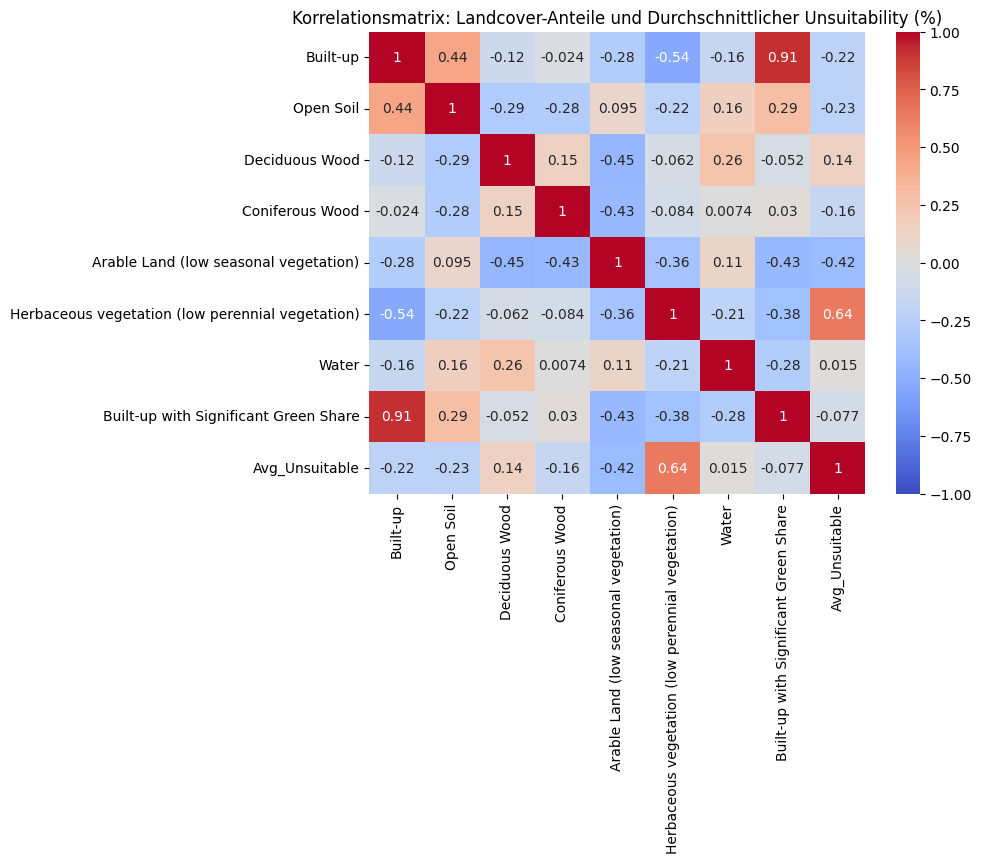

                            OLS Regression Results                            
Dep. Variable:         Avg_Unsuitable   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     3.642
Date:                Thu, 27 Mar 2025   Prob (F-statistic):             0.0220
Time:                        07:17:09   Log-Likelihood:                -56.366
No. Observations:                  21   AIC:                             130.7
Df Residuals:                      12   BIC:                             140.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

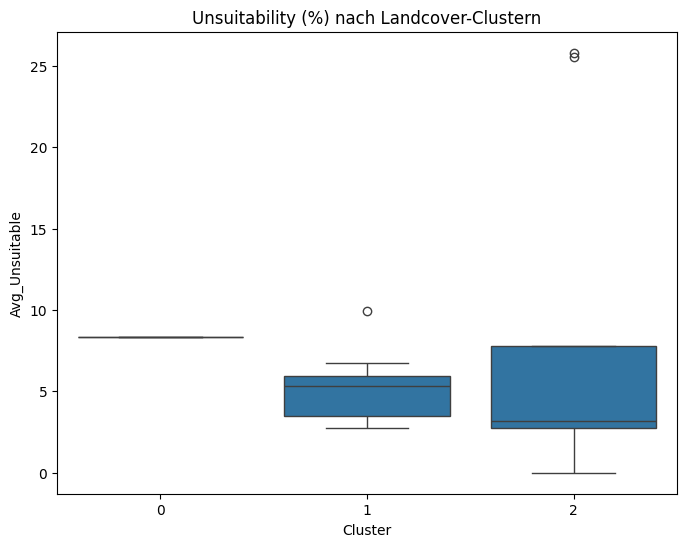

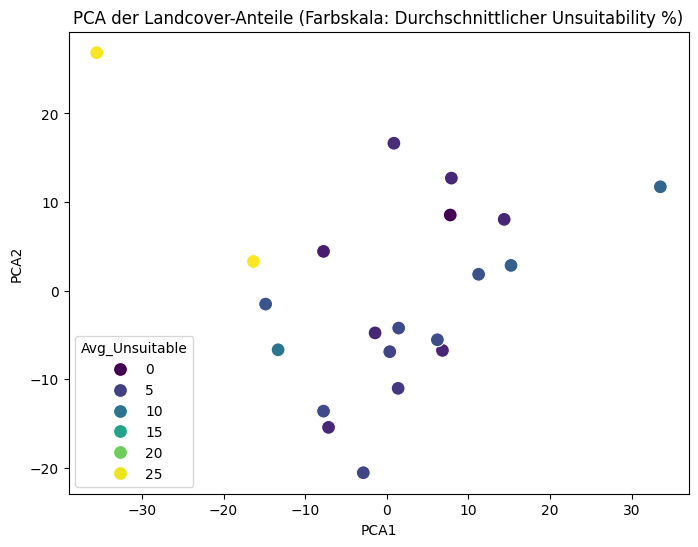

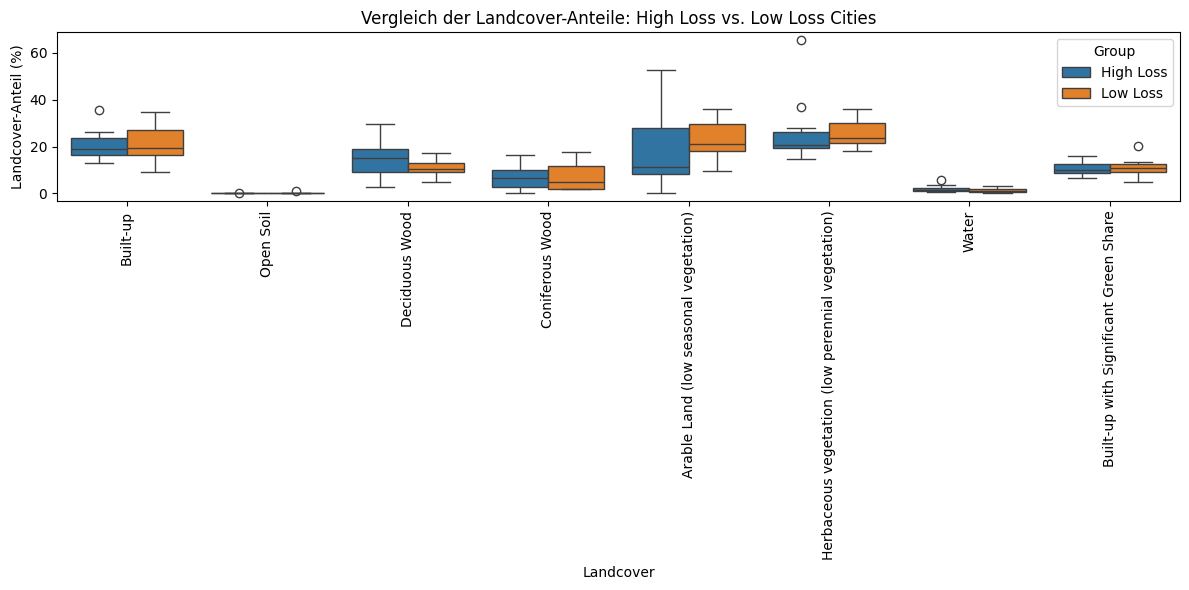

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# ---------------
# 1. Daten laden und vorbereiten
# ---------------
# Lade die Landcover Share Daten (exportiert aus deinem Landcover-Analyse-Code)
df_landcover = pd.read_csv('landcover_share.csv', index_col='City')

# Lade die Ergebnisse der Klima-Envelope-Analyse (results.csv)
df_results = pd.read_csv('results.csv')

# Berechne den unsuitability-Wert (100 - PCT_VALID) für jede Zeile
df_results['Unsuitable'] = 100 - df_results['PCT_VALID']

# Aggregiere den unsuitability-Wert pro Stadt
city_unsuitability = df_results.groupby('City')['Unsuitable'].mean()

# Kombiniere die Landcover-Daten mit dem aggregierten unsuitability-Wert.
# Dabei gehen wir davon aus, dass die Städtenamen in beiden Datensätzen übereinstimmen.
df_combined = df_landcover.copy()
df_combined['Avg_Unsuitable'] = city_unsuitability

print("Combined DataFrame:")
print(df_combined.head())

# ---------------
# 2. Korrelationsanalyse
# ---------------
# Berechne die Korrelationsmatrix für die Landcover-Anteile und Avg_Unsuitable.
corr = df_combined.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Korrelationsmatrix: Landcover-Anteile und Durchschnittlicher Unsuitability (%)")
plt.show()

# ---------------
# 3. Regressionsanalyse
# ---------------
# Wir möchten untersuchen, inwieweit die Landcover-Anteile den Avg_Unsuitable-Wert vorhersagen.
# Die unabhängigen Variablen sind alle Landcover-Klassen (die Spalten im df_landcover).
X = df_combined[df_landcover.columns]
y = df_combined['Avg_Unsuitable']

# Füge einen konstanten Term hinzu
X_const = sm.add_constant(X)

# OLS Regression durchführen
model = sm.OLS(y, X_const).fit()
print(model.summary())

# ---------------
# 4. Cluster-Analyse
# ---------------
# Clustere die Städte basierend auf ihren Landcover-Anteilen (z.B. in 3 Cluster).
features = df_combined[df_landcover.columns]
kmeans = KMeans(n_clusters=3, random_state=42)
df_combined['Cluster'] = kmeans.fit_predict(features)

# Visualisiere die Verteilung des unsuitability-Werts in den Clustern
plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='Avg_Unsuitable', data=df_combined)
plt.title("Unsuitability (%) nach Landcover-Clustern")
plt.show()

# ---------------
# 5. PCA (Principal Component Analysis)
# ---------------
# Führe PCA auf den Landcover-Anteilen durch, um die Daten in 2 Dimensionen zu projizieren.
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
df_combined['PCA1'] = pca_result[:, 0]
df_combined['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Avg_Unsuitable', data=df_combined, palette='viridis', s=100)
plt.title("PCA der Landcover-Anteile (Farbskala: Durchschnittlicher Unsuitability %)")
plt.show()

# ---------------
# 6. Vergleichsanalyse
# ---------------
# Teile die Städte in zwei Gruppen ein: 'High Loss' (Avg_Unsuitable >= Median) und 'Low Loss' (unter Median)
median_unsuitability = df_combined['Avg_Unsuitable'].median()
df_combined['Group'] = np.where(df_combined['Avg_Unsuitable'] >= median_unsuitability, 'High Loss', 'Low Loss')

# Um die Landcover-Anteile zu vergleichen, schmelzen wir den DataFrame:
df_melt = df_landcover.reset_index().melt(id_vars='City', var_name='Landcover', value_name='Share')
# Füge die Gruppierung hinzu (über einen Merge)
df_melt = df_melt.merge(df_combined[['Avg_Unsuitable', 'Group']], left_on='City', right_index=True)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Landcover', y='Share', hue='Group', data=df_melt)
plt.xticks(rotation=90)
plt.title("Vergleich der Landcover-Anteile: High Loss vs. Low Loss Cities")
plt.ylabel("Landcover-Anteil (%)")
plt.tight_layout()
plt.show()


                                          Landcover    t_stat   p_value
0                                          Built-up -0.181678  0.857967
1                                         Open Soil -1.246775  0.239661
2                                    Deciduous Wood  1.527755  0.147189
3                                   Coniferous Wood  0.011524  0.990929
4             Arable Land (low seasonal vegetation) -0.749640  0.464654
5  Herbaceous vegetation (low perennial vegetation)  0.140867  0.890022
6                                             Water  1.198197  0.247793
7             Built-up with Significant Green Share -0.361738  0.722314


<ipython-input-5-c265a0bd03a1>:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped_labels, rotation=0)  # Set labels horizontal


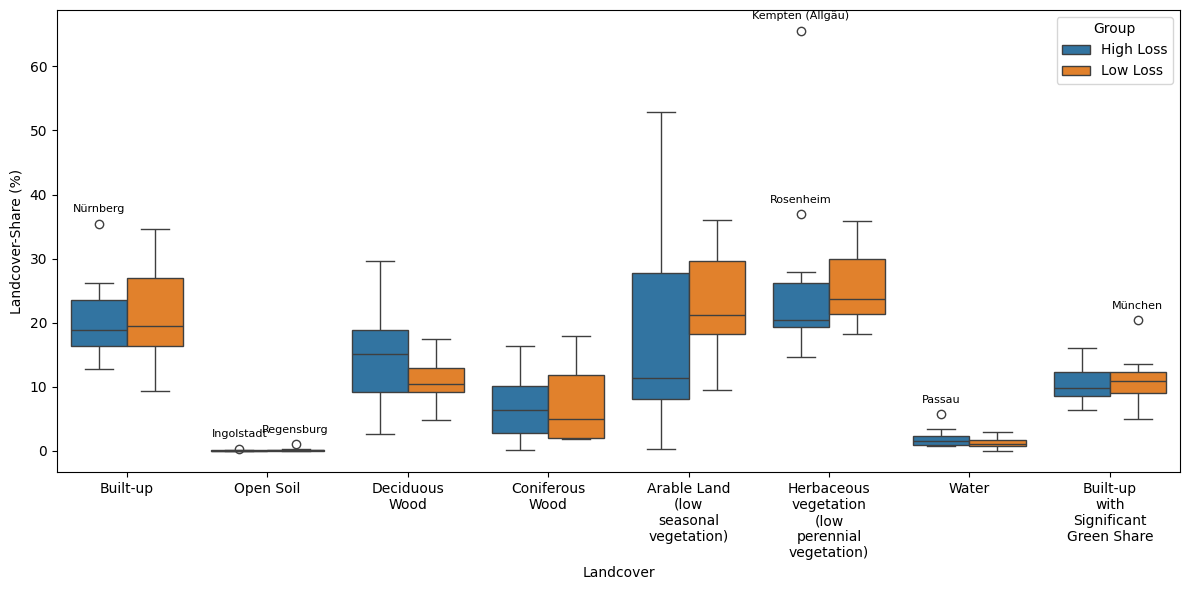

In [ ]:
import scipy.stats as stats
import pandas as pd

# Initialize an empty list to store results
results = []

# Loop over each unique landcover category
for lc in df_melt['Landcover'].unique():
    # Filter data for the current landcover and each group
    high_loss = df_melt[(df_melt['Landcover'] == lc) & (df_melt['Group'] == 'High Loss')]['Share']
    low_loss  = df_melt[(df_melt['Landcover'] == lc) & (df_melt['Group'] == 'Low Loss')]['Share']

    # Perform a t-test (Welch's t-test for unequal variances)
    t_stat, p_value = stats.ttest_ind(high_loss, low_loss, equal_var=False)

    # Append the results to our list
    results.append({'Landcover': lc, 't_stat': t_stat, 'p_value': p_value})

# Convert the results to a DataFrame for a nicer display
results_df = pd.DataFrame(results)
print(results_df)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import textwrap

# Assuming df_combined, df_landcover, and df_melt have been defined as in your code

# Group assignment based on the median of 'Avg_Unsuitable'
median_unsuitability = df_combined['Avg_Unsuitable'].median()
df_combined['Group'] = np.where(df_combined['Avg_Unsuitable'] >= median_unsuitability, 'High Loss', 'Low Loss')

# Melt the landcover DataFrame and merge with group information
df_melt = df_landcover.reset_index().melt(id_vars='City', var_name='Landcover', value_name='Share')
df_melt = df_melt.merge(df_combined[['Avg_Unsuitable', 'Group']], left_on='City', right_index=True)

# Define explicit order for consistency in plotting and annotation
landcover_order = list(df_melt['Landcover'].unique())
hue_order = ['High Loss', 'Low Loss']  # adjust this order as desired

# Create the boxplot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Landcover', y='Share', hue='Group', data=df_melt,
                 order=landcover_order, hue_order=hue_order)
#plt.title("Vergleich der Landcover-Anteile: High Loss vs. Low Loss Cities")
plt.ylabel("Landcover-Share (%)")

# Wrap long x-axis labels (e.g., if a label exceeds 10 characters, it will be split)
wrapped_labels = [textwrap.fill(label, width=12) for label in landcover_order]
ax.set_xticklabels(wrapped_labels, rotation=0)  # Set labels horizontal

# Offset for text annotation above the outlier points
text_offset = 1.8  # adjust as needed

# Annotate outliers with city names using the 1.5*IQR rule
# For each combination of Landcover and Group:
for landcover in landcover_order:
    for group in hue_order:
        subdata = df_melt[(df_melt['Landcover'] == landcover) & (df_melt['Group'] == group)]
        if subdata.empty:
            continue
        # Calculate quartiles and IQR
        q1 = subdata['Share'].quantile(0.25)
        q3 = subdata['Share'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Identify outliers
        outliers = subdata[(subdata['Share'] < lower_bound) | (subdata['Share'] > upper_bound)]

        # Determine the x-coordinate for annotation:
        # Seaborn’s boxplot with hue “dodges” the boxes.
        # With 2 groups and default box width ~0.8, we approximate offsets as -0.2 and +0.2.
        offset = -0.2 if group == hue_order[0] else 0.2
        x_coord = landcover_order.index(landcover) + offset

        # Annotate each outlier with its city name, placing text a little above the point
        for idx, row in outliers.iterrows():
            ax.text(x_coord, row['Share'] + text_offset, row['City'],
                    horizontalalignment='center', color='black', fontsize=8)

plt.tight_layout()
plt.show()





Combined Data:
             Built-up  Open Soil  Deciduous Wood  Coniferous Wood  Ackerland  \
City                                                                           
Ingolstadt  18.447981   0.315070       13.251982         1.434413  34.639595   
München     34.661221   0.257888       10.560787         2.019978   9.429978   
Rosenheim   19.637372   0.004601       16.352074         3.918273   8.318517   
Dachau      16.192195   0.053096       10.339530         1.941945  36.005626   
Freising     9.278248   0.171015       14.318696         6.815742  27.709184   

            Arable Land (Low Seasonal Vegetation)     Water  \
City                                                          
Ingolstadt                              20.011569  2.847995   
München                                 22.024904  0.661851   
Rosenheim                               36.964481  1.344970   
Dachau                                  24.833229  0.558634   
Freising                                35.854

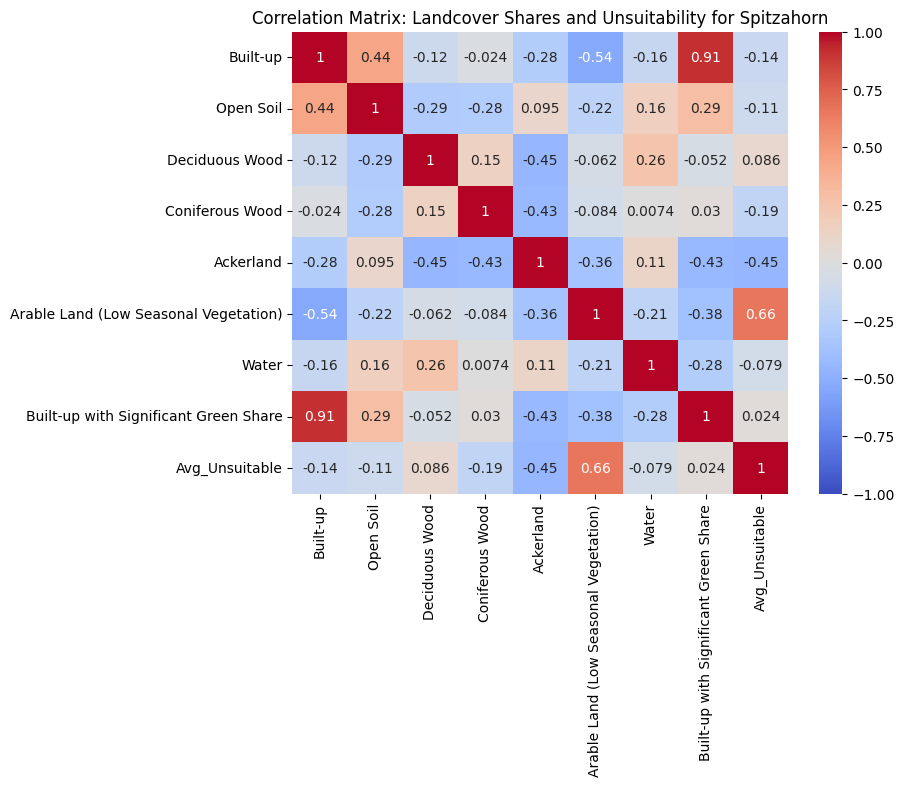

                            OLS Regression Results                            
Dep. Variable:         Avg_Unsuitable   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     3.398
Date:                Fri, 21 Mar 2025   Prob (F-statistic):             0.0280
Time:                        14:03:53   Log-Likelihood:                -81.506
No. Observations:                  21   AIC:                             181.0
Df Residuals:                      12   BIC:                             190.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

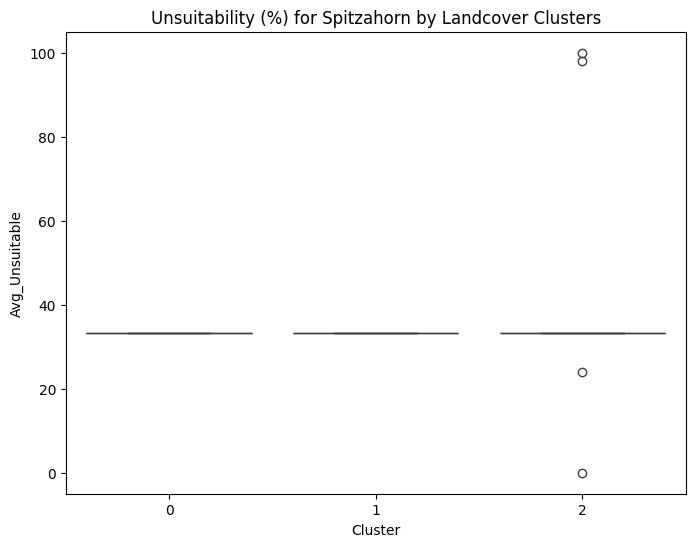

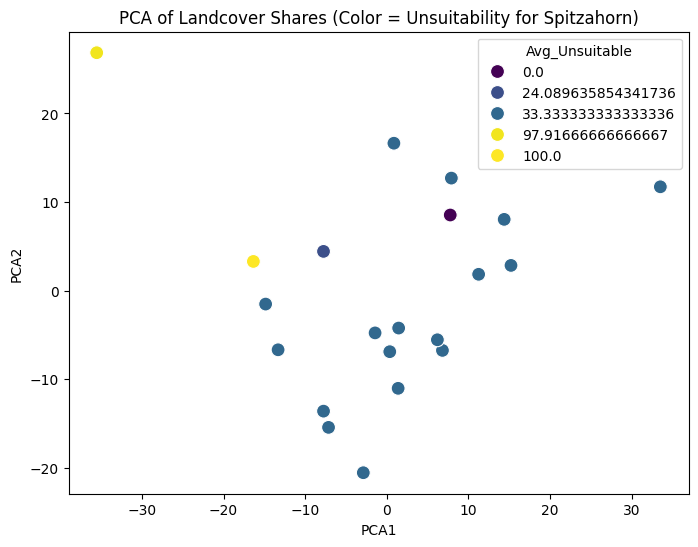

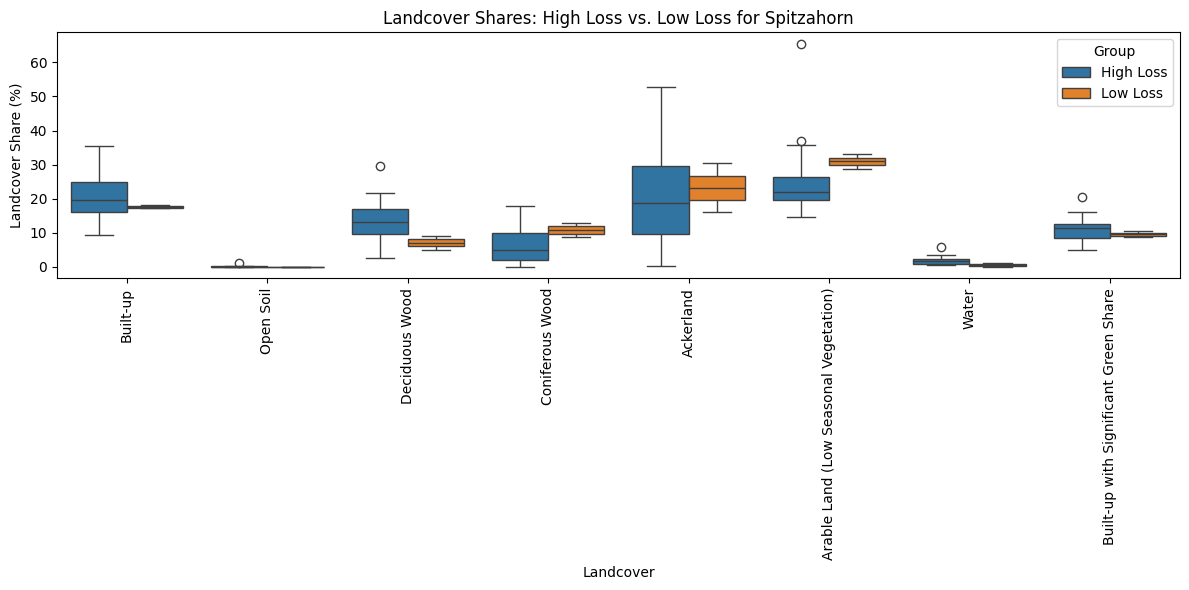

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# -----------------------------------------
# 1. Load Data
# -----------------------------------------
# Load landcover share data (from your landcover analysis CSV)
df_landcover = pd.read_csv('landcover_share.csv', index_col='City')

# Load results from the climate envelope analysis
df_results = pd.read_csv('results.csv')

# -----------------------------------------
# 2. Choose a Specific Species
# -----------------------------------------
selected_species = "Spitzahorn"  # Change this to your species of interest

# Filter the results for the selected species
df_species = df_results[df_results['Species'] == selected_species].copy()

# -----------------------------------------
# 3. Compute Unsuitability and Aggregate per City
# -----------------------------------------
# Compute unsuitability as 100 - PCT_VALID
df_species['Unsuitable'] = 100 - df_species['PCT_VALID']

# Aggregate unsuitability per city (using mean if multiple time frames exist)
city_unsuitability = df_species.groupby('City')['Unsuitable'].mean()

# -----------------------------------------
# 4. Merge with Landcover Share Data
# -----------------------------------------
df_combined = df_landcover.copy()
df_combined['Avg_Unsuitable'] = city_unsuitability

print("Combined Data:")
print(df_combined.head())

# -----------------------------------------
# 5. Analyses
# -----------------------------------------

# (a) Correlation Analysis: Correlation matrix between landcover shares and Avg_Unsuitable
corr = df_combined.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f"Correlation Matrix: Landcover Shares and Unsuitability for {selected_species}")
plt.show()

# (b) Regression Analysis: Predict Avg_Unsuitable using landcover shares
X = df_combined[df_landcover.columns]  # independent variables: all landcover share columns
y = df_combined['Avg_Unsuitable']        # dependent variable: unsuitability for the chosen species
X_const = sm.add_constant(X)             # add constant term for regression

model = sm.OLS(y, X_const).fit()
print(model.summary())

# (c) Cluster Analysis: Group cities based on their landcover shares
features = df_combined[df_landcover.columns]
kmeans = KMeans(n_clusters=3, random_state=42)
df_combined['Cluster'] = kmeans.fit_predict(features)

plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='Avg_Unsuitable', data=df_combined)
plt.title(f"Unsuitability (%) for {selected_species} by Landcover Clusters")
plt.show()

# (d) PCA: Reduce dimensions of the landcover data to visualize cities in 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
df_combined['PCA1'] = pca_result[:, 0]
df_combined['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Avg_Unsuitable', data=df_combined, palette='viridis', s=100)
plt.title(f"PCA of Landcover Shares (Color = Unsuitability for {selected_species})")
plt.show()

# (e) Comparative Analysis: Compare landcover shares in cities with high vs. low unsuitability
median_unsuitability = df_combined['Avg_Unsuitable'].median()
df_combined['Group'] = np.where(df_combined['Avg_Unsuitable'] >= median_unsuitability, 'High Loss', 'Low Loss')

# Reshape the landcover data for comparison via boxplots
df_melt = df_landcover.reset_index().melt(id_vars='City', var_name='Landcover', value_name='Share')
df_melt = df_melt.merge(df_combined[['Avg_Unsuitable', 'Group']], left_on='City', right_index=True)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Landcover', y='Share', hue='Group', data=df_melt)
plt.xticks(rotation=90)
plt.title(f"Landcover Shares: High Loss vs. Low Loss for {selected_species}")
plt.ylabel("Landcover Share (%)")
plt.tight_layout()
plt.show()


In [ ]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# 1. Load and filter the shapefile
# ------------------------------
shapefile_path = "VG250_GEM.shp"
gdf = gpd.read_file(shapefile_path)

ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf['ARS_0'].isin(ars_list)].copy()

# ------------------------------
# 2. Land-cover raster setup
# ------------------------------
# Path to your land-cover GeoTIFF (with 8 classes)
landcover_path = "ugr2018_germany.tif"

# Land-cover classes mapping (1 to 8)
landcover_classes = {
    1: 'Built-up',
    2: 'Open Soil',
    3: 'Deciduous Wood',
    4: 'Coniferous Wood',
    5: 'Ackerland',
    6: 'Arable Land (Low Seasonal Vegetation)',
    7: 'Water',
    8: 'Built-up with Significant Green Share'
}

# Reproject the shapefile to the raster’s CRS if needed.
with rasterio.open(landcover_path) as src:
    landcover_crs = src.crs

if gdf_filtered.crs != landcover_crs:
    gdf_filtered = gdf_filtered.to_crs(landcover_crs)

# ------------------------------
# 3. Calculate land-cover share for each city
# ------------------------------
results_landcover = []

with rasterio.open(landcover_path) as src:
    for idx, row in gdf_filtered.iterrows():
        city = row["GEN"]
        polygon = row.geometry

        # Mask the raster using the city polygon
        out_image, out_transform = mask(src, [polygon.__geo_interface__],
                                        crop=True, all_touched=True, filled=True)
        data = out_image[0]  # assume a single band

        # Create a mask to select only pixels that fall within the polygon
        poly_mask = geometry_mask([polygon.__geo_interface__],
                                  out_shape=data.shape,
                                  transform=out_transform,
                                  invert=True)
        # Extract only the pixels within the polygon
        data_inside = data[poly_mask]
        total_pixels = data_inside.size

        if total_pixels == 0:
            continue

        # Count pixels for each land-cover class (ignoring any nodata or background if present)
        unique, counts = np.unique(data_inside, return_counts=True)
        counts_dict = dict(zip(unique, counts))

        # Calculate percentage share for each class
        shares = {}
        for cls in range(1, 9):
            count = counts_dict.get(cls, 0)
            share = count / total_pixels * 100
            shares[landcover_classes[cls]] = share

        shares['City'] = city
        results_landcover.append(shares)

# Convert results to a DataFrame
df_landcover = pd.DataFrame(results_landcover)
df_landcover = df_landcover.set_index('City')
print(df_landcover)

# ------------------------------
# 4. Plotting the land-cover shares
# ------------------------------
# Create a stacked bar chart where each bar (city) is split by land-cover classes.
ax = df_landcover.plot(kind='bar', stacked=True, figsize=(14, 8))

plt.ylabel('Percentage Share (%)')
plt.title('Land Cover Share in Analysis Cities')
plt.legend(title='Land Cover Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




RasterioIOError: ugr2018_germany.tif: TIFFReadDirectory:Failed to read directory at offset 372052104

In [ ]:
!pip install contextily

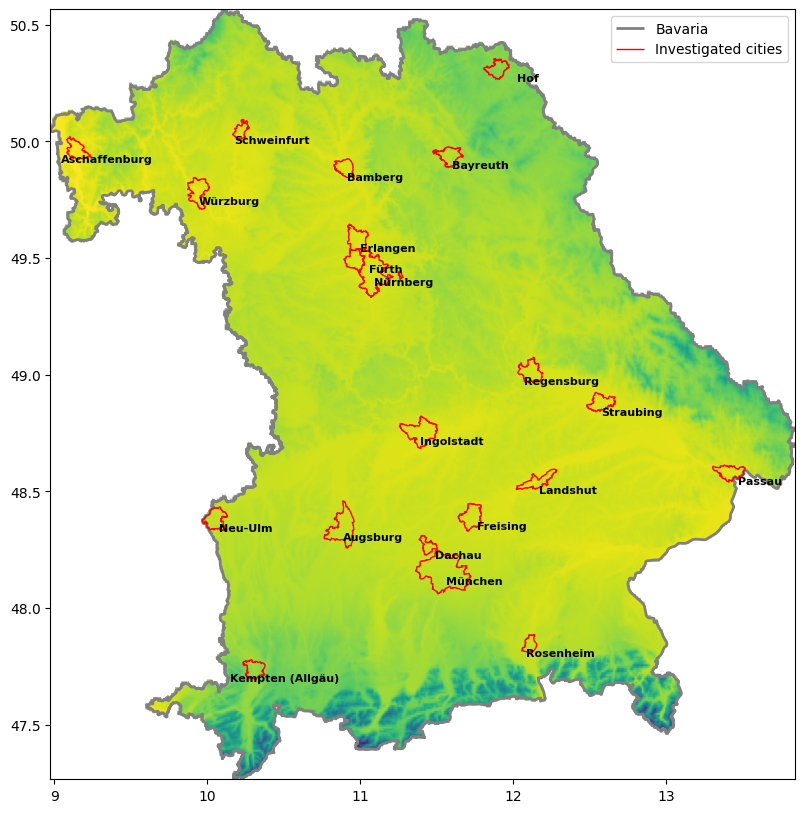

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

# 1. Shapefile laden und Spalte "ARS_0" als String formatieren
gdf = gpd.read_file("VG250_GEM.shp")
gdf['ARS_0'] = gdf['ARS_0'].astype(str)

# 2. Grenze von Bayern: Alle Features, deren ARS_0 mit "09" beginnen, zusammenführen (dissolve)
bayern = gdf[gdf['ARS_0'].str.startswith('09')].dissolve()

# 3. Filter für untersuchte Städte (wie in deinem ursprünglichen Code)
ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf['ARS_0'].isin(ars_list)].copy()

# 4. Lade den Hintergrund aus einer GeoTIFF-Datei.
#    Passe den Dateipfad nach Bedarf an.
with rasterio.open("TEmp_Bavaria.tif") as src:
    # 5. Reprojektion der Geodaten in das CRS des GeoTIFF
    bayern_proj = bayern.to_crs(src.crs)
    gdf_filtered_proj = gdf_filtered.to_crs(src.crs)

    # 6. Plot erstellen
    fig, ax = plt.subplots(figsize=(10, 10))

    # Zeige das GeoTIFF als Hintergrund
    show(src, ax=ax)

    # Plot der bayerischen Umrandung
    bayern_proj.boundary.plot(ax=ax, edgecolor='grey', linewidth=2, label="Bavaria")

    # Plot der Umrandungen der untersuchten Städte
    gdf_filtered_proj.boundary.plot(ax=ax, edgecolor='red', linewidth=1, label="Investigated cities")

    # Füge die Stadtnamen in Weiß hinzu (angenommen, der Name steht in der Spalte "GEN")
    for idx, row in gdf_filtered_proj.iterrows():
      centroid = row.geometry.centroid
      # Define your offsets (adjust these values as needed)
      offset_x = 0.2
      offset_y = -0.04
      ax.text(centroid.x + offset_x, centroid.y + offset_y, row["GEN"],
            fontsize=8, color='black', ha='center', va='center', fontweight='bold')

    #ax.set_title("Karte: GeoTIFF Hintergrund, Bayern und untersuchte Städte")
    ax.legend()
    plt.show()

